# 2. Models

## 2.1 Introduction

This notebook constitutes the second part of the analysis, following the exploratory study conducted in [the EDA Notebook](1_EDA.ipynb). Building on the insights obtained about the dataset’s structure and variability, we now focus on the modeling stage.

We analyze the various deep learning architectures explored for the image classification task on the Food-101 dataset. For this type of problem, convolutional and transformer-based neural networks are the standard approach due to their strong capacity for visual feature extraction and transfer learning.

We begin by evaluating simple baseline models such as a fully connected MLP and a small custom CNN to establish a performance reference. Subsequently, we compare several pretrained architectures including ResNet50, ViT-B/16, and GoogLeNet, fine-tuned on our dataset, and assess their respective accuracy, training efficiency, and generalization behavior.

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.engine import *
from matplotlib.ticker import MultipleLocator
from src.data import read_splits, build_transforms, make_datasets
from src.notebook.eda_utils import *
from src.notebook.models_utils import *
import torch
from torchvision.models import swin_b

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 3
img_size = 224

data_dir = os.path.join("data","food-101")
results_dir = "artifacts"
epoch_dir = os.path.join(results_dir, "per_epoch")
ckpt_dir = os.path.join(results_dir, "checkpoints")
images_dir = os.path.join(data_dir, "images")
meta_dir = os.path.join(data_dir, "meta")
test_txt = os.path.join(data_dir, "meta", "test.txt")

train_list, val_list = read_splits(meta_dir)
train_tf, val_tf = build_transforms(img_size)
train_ds, val_ds, classes = make_datasets(images_dir, train_list, val_list, train_tf, val_tf)

### 2.1.1 Performance Metrics

The Food-101 dataset contains 101 food categories, each represented by 1,000 images, for a total of 101,000 images. For model evaluation, the dataset provides a predefined split of 750 training images and 250 test images per class.

Model performance is primarily assessed using two metrics:
- **Top-1 Accuracy**: the proportion of samples for which the model’s highest-probability prediction matches the true label.
- **Top-5 Accuracy**: the proportion of samples where the correct label appears among the five most probable predictions.

These two metrics together provide a clear view of both overall precision and the model’s ability to capture relevant class candidates even when its top prediction is incorrect.

### 2.1.2 Training Components

The training pipeline relies on modular components defined in the project’s *src/* directory.
Each element plays a specific role in model optimization and experiment reproducibility.

- **Optimizer**: We use AdamW, a variant of Adam that decouples weight decay from gradient updates.
It combines the fast convergence of Adam with better regularization, which helps prevent overfitting, especially in transformer-based and large convolutional models.

- **Learning Rate Scheduler**: A OneCycleLR scheduler gradually increases the learning rate at the beginning of training, then decreases it toward the end.
This dynamic schedule helps the model converge faster and reduces the risk of being trapped in sharp minima.

- **Loss Function**: Training uses Cross-Entropy Loss with label smoothing (0.1).
Label smoothing prevents the model from becoming overconfident by assigning a small portion of the probability mass to incorrect classes, improving generalization.

- **Gradient Scaler**: The torch.amp.GradScaler enables automatic mixed precision (AMP) training.
It dynamically scales gradients to prevent underflow during FP16 operations, which accelerates training on modern GPUs without sacrificing numerical stability.

Most core parameters are defined in the YAML configuration file and passed to the script at runtime:
- **arch**: model backbone (e.g., convnext_tiny, resnet50, vit_b_16). 
- **pretrained** *(bool)*: whether to initialize the model with ImageNet weights.
- **freeze_backbone** *(bool)*: whether to freeze the feature extractor during fine-tuning.
- **batch_size**: images per update. *Kept by default at 64*
- **epochs**: number of training epochs. *Kept by default at 5 when backbone is frozen, 25 for full fine-tuning*
- **lr**: initial learning rate. *Kept by default at 3e-4*
- **weight_decay**: L2 regularization. *Kept by default at 0.01*

## 2.2 Benchmark Models (MLP and Tiny CNN)

We begin our experiments with two simple architectures trained from scratch: a Multilayer Perceptron (MLP) and a Tiny Convolutional Neural Network (TinyCNN).

These lightweight models serve as reference baselines to quantify the benefits of deeper and pretrained architectures tested later in this study.
- The **MLP** treats each image as a flat vector of pixel intensities, ignoring spatial structure. It provides a minimal learning setup to highlight the necessity of convolutional inductive biases for image data.
- The **TinyCNN** introduces a small convolutional hierarchy with roughly 200–500k parameters. Despite its simplicity, it can capture local spatial features and achieve reasonable accuracy on small subsets of the dataset.

Training these baselines helps establish a lower bound for performance and contextualizes the improvement achieved by transfer learning models such as ResNet, ViT, or ConvNeXt.

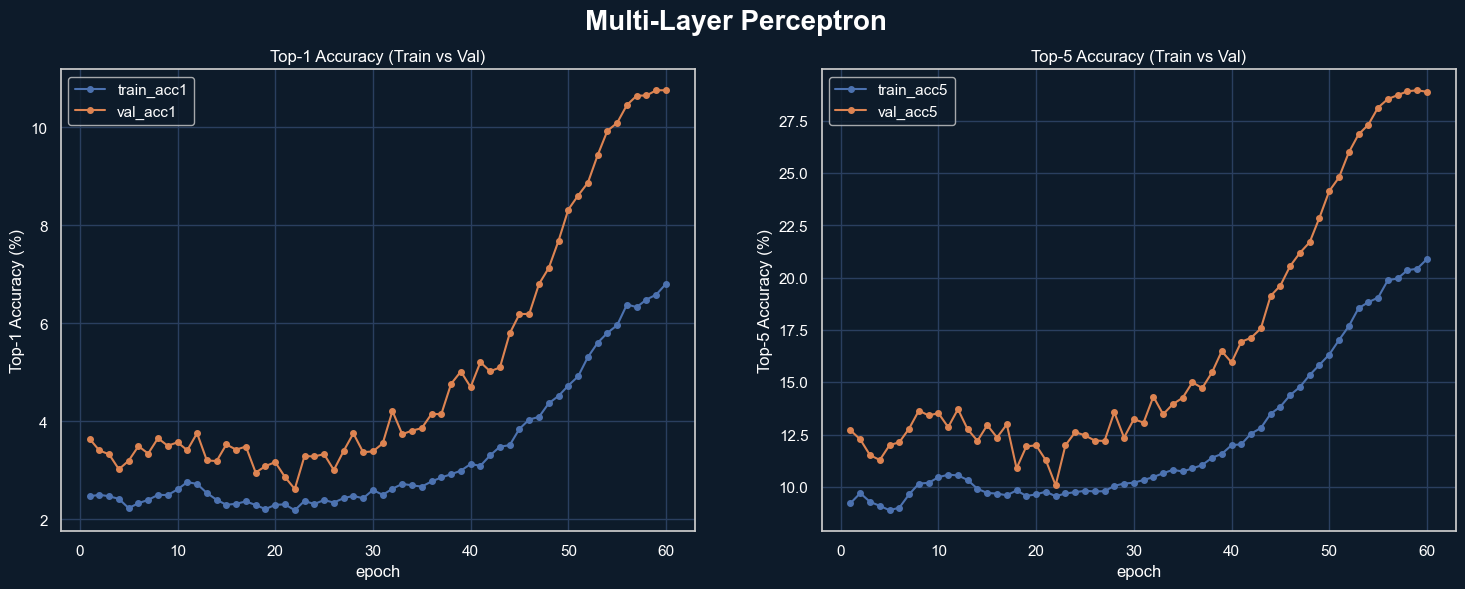

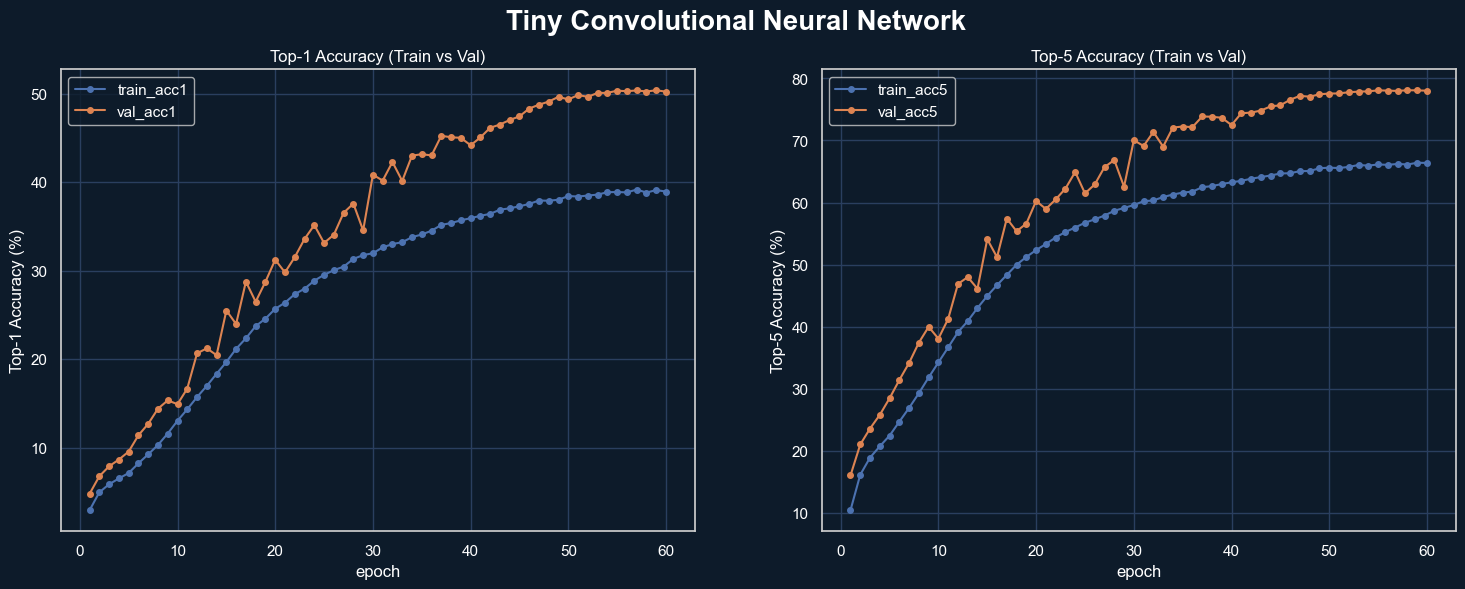

In [2]:
plot_summary("mlp_noPT_60.csv", epoch_dir, "Multi-Layer Perceptron", ms = 4)
plot_summary("tiny_cnn_noPT_60.csv", epoch_dir, "Tiny Convolutional Neural Network", ms = 4)

The results clearly show that both baseline models have limited performance on the Food-101 dataset.
After 60 training epochs, the observed metrics (on the validation set) are as follows:
- MLP: Top-1 Accuracy at 11%, Top-5 Accuracy at 28%
- TinyCNN: Top-1 Accuracy at 50%, Top-5 Accuracy at 80%

These outcomes confirm that a simple fully connected network is unable to capture the spatial structure of images, while even a small convolutional model can leverage local patterns to achieve substantially better results.
Nevertheless, the TinyCNN remains far below the performance levels typically achieved by modern pretrained architectures, reinforcing the importance of transfer learning for large-scale image recognition tasks.

## 2.3 Definition: Transfer Learning with Pretrained Weights

To establish a stronger baseline, we now introduce a larger convolutional architecture: ResNet50 and train it using pretrained ImageNet weights.
ResNet50 was chosen because it remains one of the most reliable and widely adopted CNN backbones in computer vision. With its **25M** parameters, it is regarded as an excellent balance between accuracy, computational cost, and model size, which explains why it remains a standard reference architecture in both research and production.

Using pretrained weights leverages **transfer learning**, a technique that initializes the network with features already learned from a large and diverse dataset such as **ImageNet**.
Instead of starting from random parameters, the model begins with a meaningful understanding of low- and mid-level visual patterns (edges, textures, colors, shapes).
Fine-tuning these representations on the Food-101 dataset drastically accelerates convergence and improves accuracy, particularly when the target dataset is smaller or less diverse.

This approach typically delivers substantial gains in both training efficiency and final performance, as the network adapts pre-existing knowledge to the specific domain of food recognition.

There are two main strategies for applying transfer learning:
- **Freezing the backbone**, which trains only the classification head while keeping the pretrained feature extractor fixed. This approach is faster and requires fewer resources, but limits the model’s ability to adapt to domain-specific features.
- **Full fine-tuning**, where all layers are updated during training. This method is computationally heavier but allows the network to adjust its learned representations more precisely to the characteristics of the new dataset.

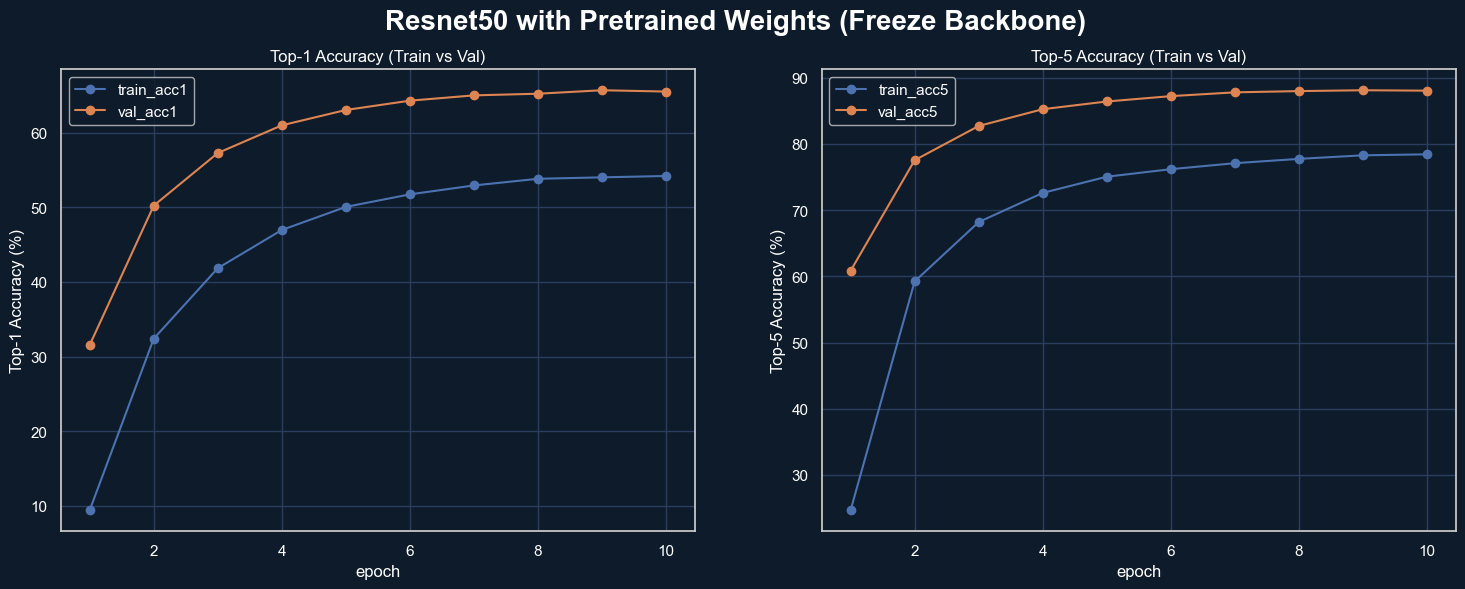

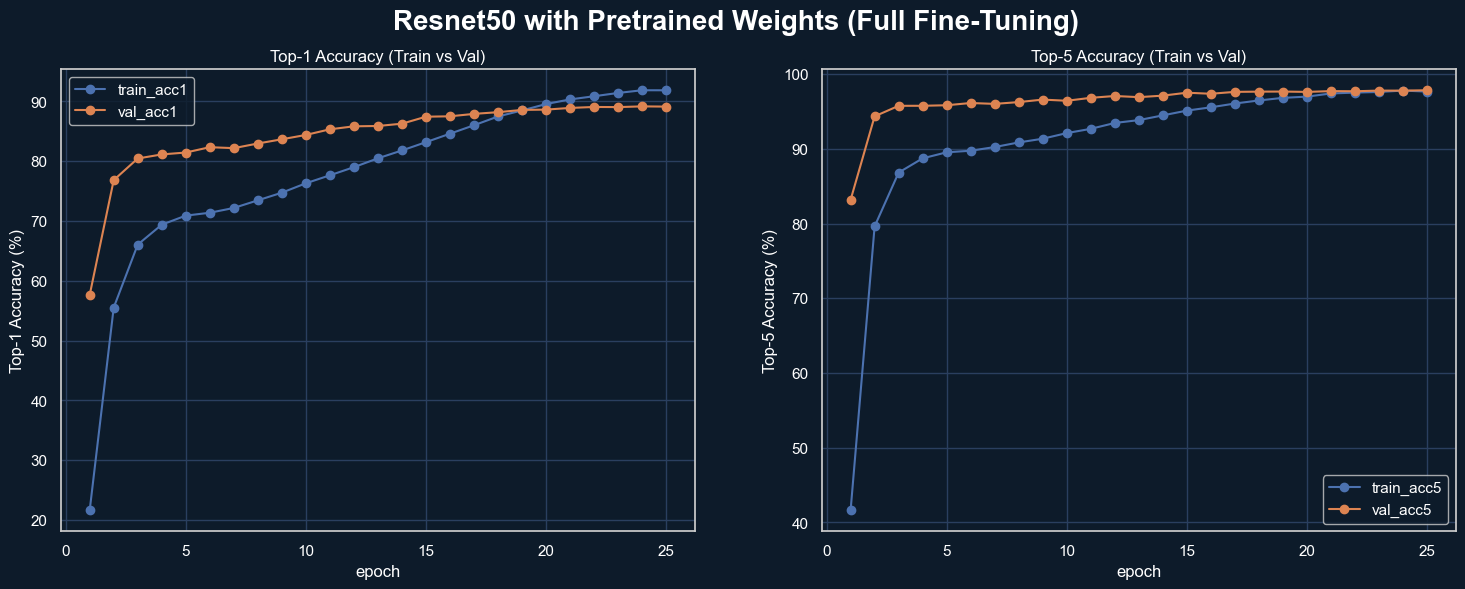

In [3]:
plot_summary("resnet50_10.csv", epoch_dir, "Resnet50 with Pretrained Weights (Freeze Backbone)",ms = 6)
plot_summary("resnet50_noFB_25.csv", epoch_dir, "Resnet50 with Pretrained Weights (Full Fine-Tuning)",ms = 6)

The improvement from transfer learning is immediately visible.
Using ResNet50 pretrained on ImageNet, the model achieves significantly higher accuracy compared to the scratch baselines:
- Backbone Frozen: Top-1 Accuracy 65.5%, Top-5 Accuracy 88.0% after only 10 epochs
- Full Fine-Tuning: Top-1 Accuracy 89.2%, Top-5 Accuracy 97.7% after only 25 epochs

These results confirm the efficiency of pretrained feature extractors and the substantial performance gain obtained through full fine-tuning on the Food-101 dataset.

Now that we have observed the impact of transfer learning with ResNet50, we extend our analysis to several architecture families representing the main design paradigms in deep learning for image classification.
Each family reflects a distinct evolution in network design, from early convolutional structures to hybrid convolution-transformer models.

- **ResNets (ResNet18, ResNet50, ResNet101, Wide-ResNet50-2)** :
Introduced the concept of residual connections, enabling very deep networks to train effectively without gradient vanishing. They are reliable, well-balanced architectures widely used as strong baselines.

- **VGG / Classic CNNs (VGG16)** :
One of the earliest deep CNNs based on simple, sequential 3×3 convolutions. Though computationally heavy, it remains a historical reference for understanding deep feature hierarchies.

- **Dense / Efficient CNNs (DenseNet121, EfficientNet-B0/B7, MnasNet, MobileNetV3, RegNet)** :
Designed for efficiency and compactness. These models optimize parameter reuse and network scaling, achieving competitive accuracy with fewer parameters and faster inference, ideal for mobile or resource-constrained environments.

- **Inception-like (GoogLeNet, InceptionV3)** : 
Combine multiple convolutional kernels of different sizes within the same block to capture multi-scale features efficiently. They balance accuracy and computational cost well.

- **Transformers (ViT-B/16, ViT-L/16, Swin-T, Swin-B)** : 
Transformer-based vision architectures that replace convolutions with self-attention mechanisms to model long-range dependencies and global context. They represent a paradigm shift toward data-driven representation learning, often delivering state-of-the-art accuracy at higher computational and data requirements.

- **ConvNeXt (ConvNeXt-Tiny, ConvNeXt-Small)** :
A modern convolutional architecture inspired by design principles and training strategies from Vision Transformers. It retains a purely convolutional structure but incorporates Transformer-era elements, such as large kernel depthwise convolutions, LayerNorm, and GELU activation, achieving competitive performance while preserving CNN efficiency.

This diverse set of architectures allows for a comprehensive comparison between classical convolutional designs and modern attention-based models, illustrating how model structure influences both performance and efficiency on the Food-101 dataset.

## 2.4 Architectures Benchmark

### 2.4.1 Structures

We compiled, from the PyTorch model zoo and the official repositories of each architecture, the main structural characteristics of the networks:
- **Number of parameters**: the total count of trainable weights in the model. This value reflects the capacity and memory footprint of the network and directly influences both training time and overfitting risk.
- **FLOPs (Floating Point Operations)**: an estimation of the number of floating-point computations required for a single forward pass at the standard input resolution. It provides an approximate measure of computational cost and allows comparing the theoretical efficiency of different architectures independently of hardware or implementation.

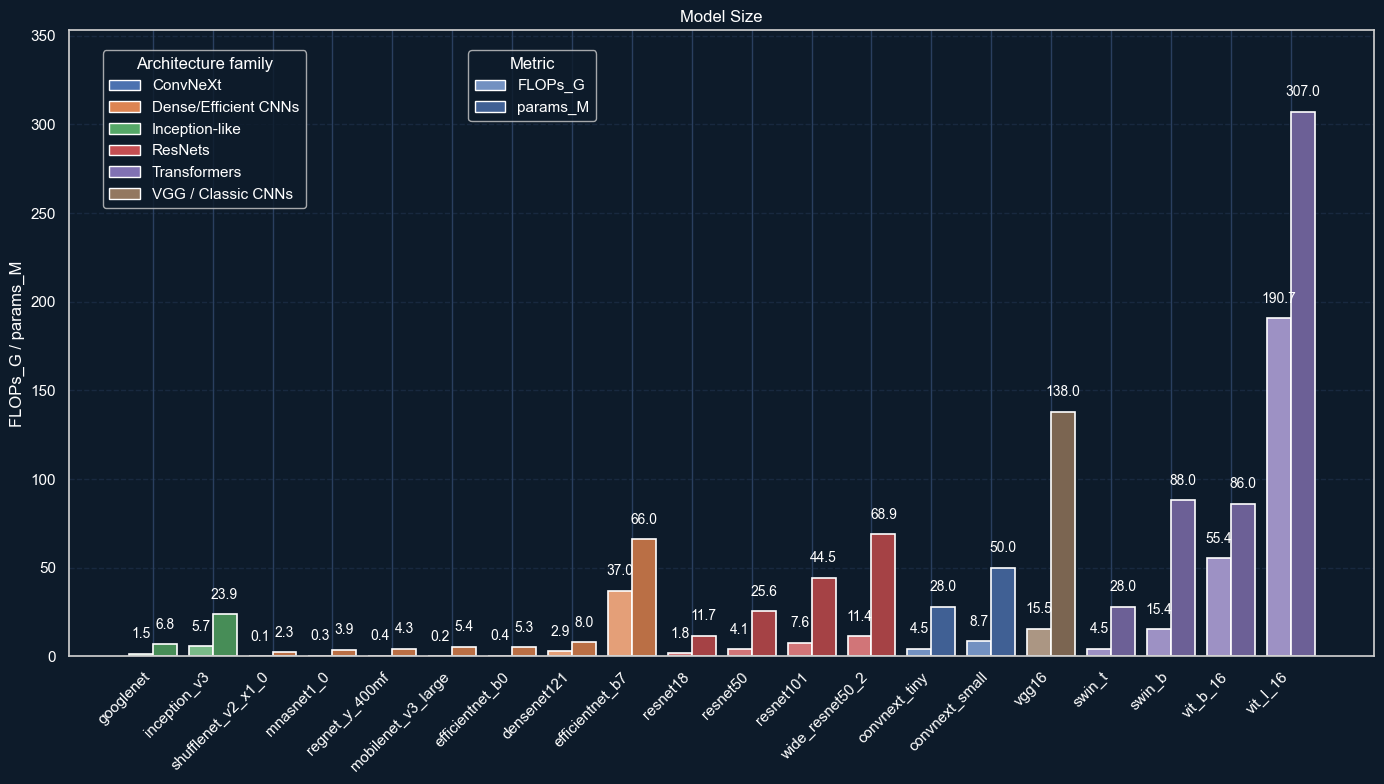

In [4]:
arch2cat = {
    "resnet18":         "ResNets",
    "resnet50":         "ResNets",
    "resnet101":        "ResNets",
    "wide_resnet50_2":  "ResNets",

    "vgg16":            "VGG / Classic CNNs",

    "densenet121":         "Dense/Efficient CNNs",
    "efficientnet_b0":     "Dense/Efficient CNNs",
    "efficientnet_b7":     "Dense/Efficient CNNs",
    "mnasnet1_0":          "Dense/Efficient CNNs",
    "mobilenet_v3_large":  "Dense/Efficient CNNs",
    "regnet_y_400mf":      "Dense/Efficient CNNs",
    "shufflenet_v2_x1_0":  "Dense/Efficient CNNs",

    "googlenet":        "Inception-like",
    "inception_v3":     "Inception-like",
    
    "vit_l_16":          "Transformers",
    "vit_b_16":          "Transformers",
    "swin_t":            "Transformers",
    "swin_b":            "Transformers",
    "convnext_small": "ConvNeXt",
    "convnext_tiny":  "ConvNeXt",
}

dt_params = pd.read_csv("data/Model_architecture_characteristics.csv")

plot_grouped_bars(
    epoch_dir, arch2cat, suffixes=["5", "noFB_25"], suffix_labels=["Backbone Freeze", "Full Fine Tune"],
    metric="model_size",agg="mean",scale=1.0,title="Model Size", arch_df = dt_params
);

The set includes a wide range of architectures, from compact models like ShuffleNet with 2.3 million parameters to large networks such as ViT-L/16 exceeding 300 million. This diversity illustrates the trade-off between computational efficiency and representational power.

Lightweight models such as ShuffleNet, MobileNet, and MNASNet are optimized for limited hardware, focusing on speed and reduced memory usage, often at the cost of accuracy. Larger networks like ResNet101, ConvNeXt, or Vision Transformers employ more parameters and higher FLOPs to achieve superior performance but require significantly more computation and training time.

Overall, this contrast highlights the evolution from classical convolutional structures to modern transformer-based designs, offering a clear view of how model complexity influences runtime and accuracy.

### 2.4.2 Running Time

In this section, we focus on the temporal performance of each model that we have run, observing how long a complete training epoch takes and how efficiently the model processes data during both training and validation.

By studying the runtime per epoch, we can better understand the computational cost associated with each architecture. This includes evaluating how model complexity, batch size, and updating methods (backbone frozen vs full fine-tuning) impact the overall training duration and throughput. Such analysis is essential to contextualize the accuracy results: higher accuracy is valuable only when balanced with feasible training and inference times.

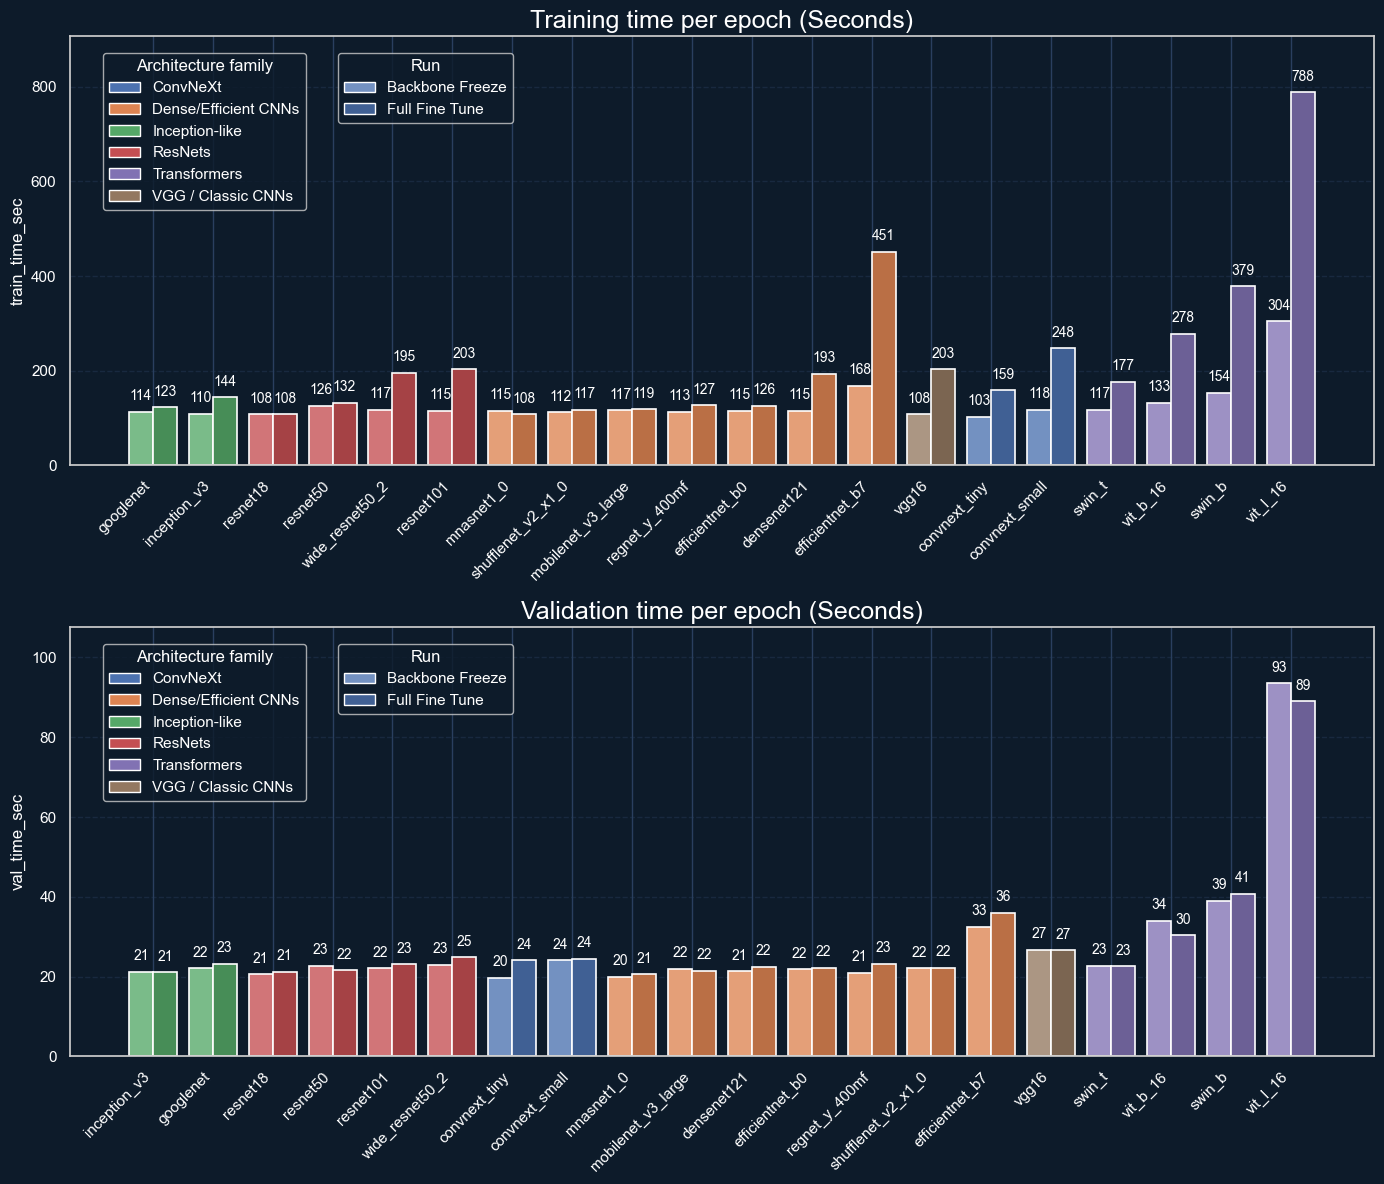

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(14, 12))
plt.rcParams["axes.titlesize"] = 18
plot_grouped_bars(
    epoch_dir, arch2cat, suffixes=["5", "noFB_25"], suffix_labels=["Backbone Freeze", "Full Fine Tune"],
    metric="train_time_sec",agg="mean",scale=1.0,title="Training time per epoch (Seconds)", ax=axes[0]
)
plot_grouped_bars(
    epoch_dir , arch2cat, suffixes=["5", "noFB_25"], suffix_labels=["Backbone Freeze", "Full Fine Tune"],
    metric="val_time_sec",agg="mean",scale=1.0,title="Validation time per epoch (Seconds)", ax=axes[1]
)
plt.tight_layout()
plt.show()

As expected, smaller architectures are also the fastest to train. When training only the classification head (with the backbone frozen), most models complete an epoch in roughly two minutes under the current hardware configuration. The only significant exception is *vit_l_16*, which requires around five minutes per epoch due to its larger transformer backbone.

Full fine-tuning consistently results in longer training times, which is expected since all model parameters are updated. For the majority of architectures, this increase remains moderate (about 5 to 10% longer per epoch). However, for models such as ConvNeXt, the transformer-based variants (and efficientnet_b7), the difference becomes much more pronounced, sometimes doubling or even tripling the total training time. This slower performance stems from their higher parameter counts and more complex layer structures, which make gradient computations and weight updates substantially heavier during full fine-tuning.

Validation time per epoch tends to remain stable regardless of whether the backbone is frozen, as it depends mainly on forward passes rather than gradient updates. Once again, *vit_l_16* stands out for its noticeably slower validation phase compared with the rest of the models.

### 2.4.3 File Size

We will also look at the final checkpoint file size after training, which reflects the storage footprint and indirectly the model’s parameter count. Together, these metrics provide a practical perspective on model efficiency. A model that achieves strong accuracy with moderate training time and a compact checkpoint represents a more balanced and deployable solution. This joint analysis of speed, resource demand, and model size complements the accuracy comparisons and highlights trade-offs relevant for real-world deployment scenarios.

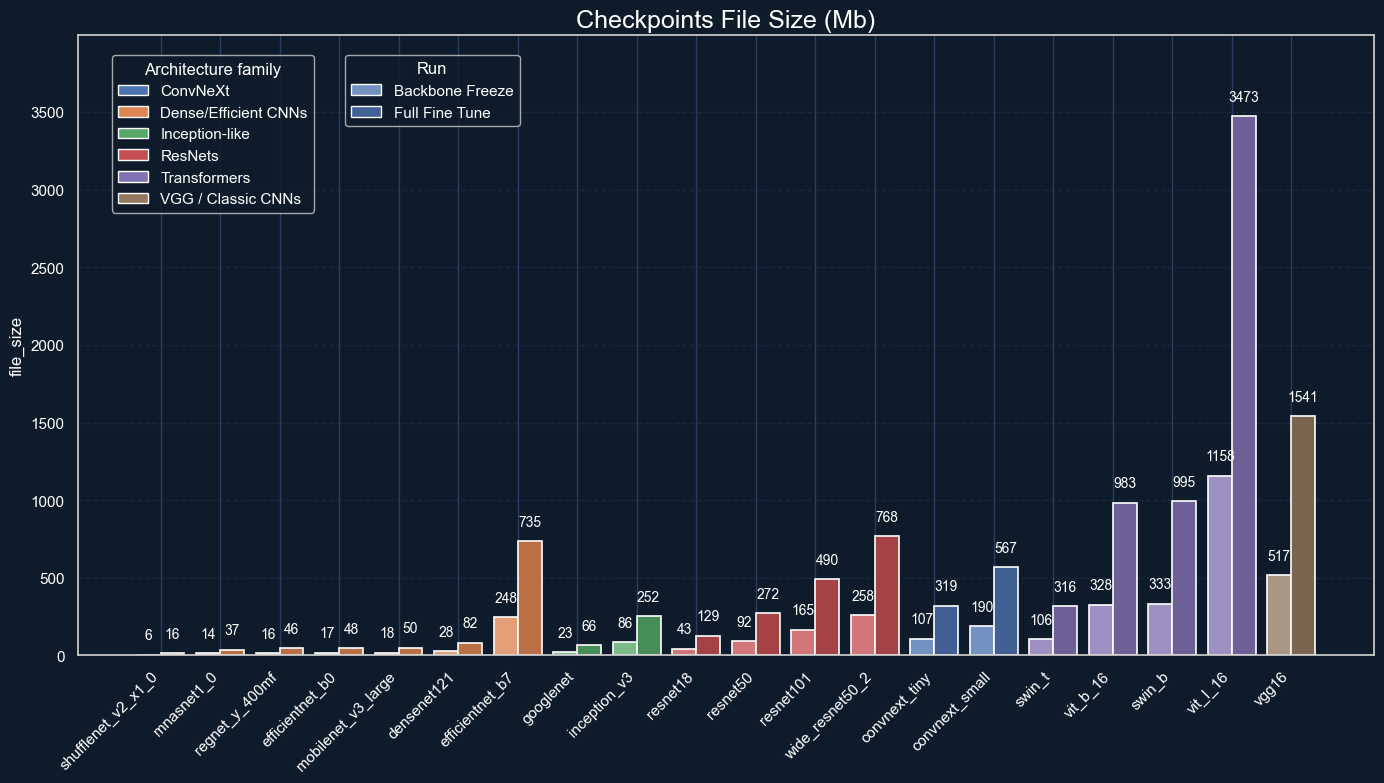

In [6]:
plot_grouped_bars(
    ckpt_dir , arch2cat, suffixes=["5", "noFB_25"], suffix_labels=["Backbone Freeze", "Full Fine Tune"],
    metric="file_size",scale=1.0,title="Checkpoints File Size (Mb)"
);

This difference extends beyond storage: fully fine-tuned models also require more memory bandwidth and gradient computations, which slows down each iteration and increases the overall training time per epoch. Conversely, head-only models benefit from reduced computational load because most of the backbone remains static, allowing faster epochs and lower GPU utilization. The relationship between model size, parameter count, and runtime is therefore nearly proportional, illustrating how architectural complexity directly translates into computational and storage costs.

### 2.4.4 Performance (Accuracy)

#### 2.4.4.1 Head-only Models (Backbone Frozen)

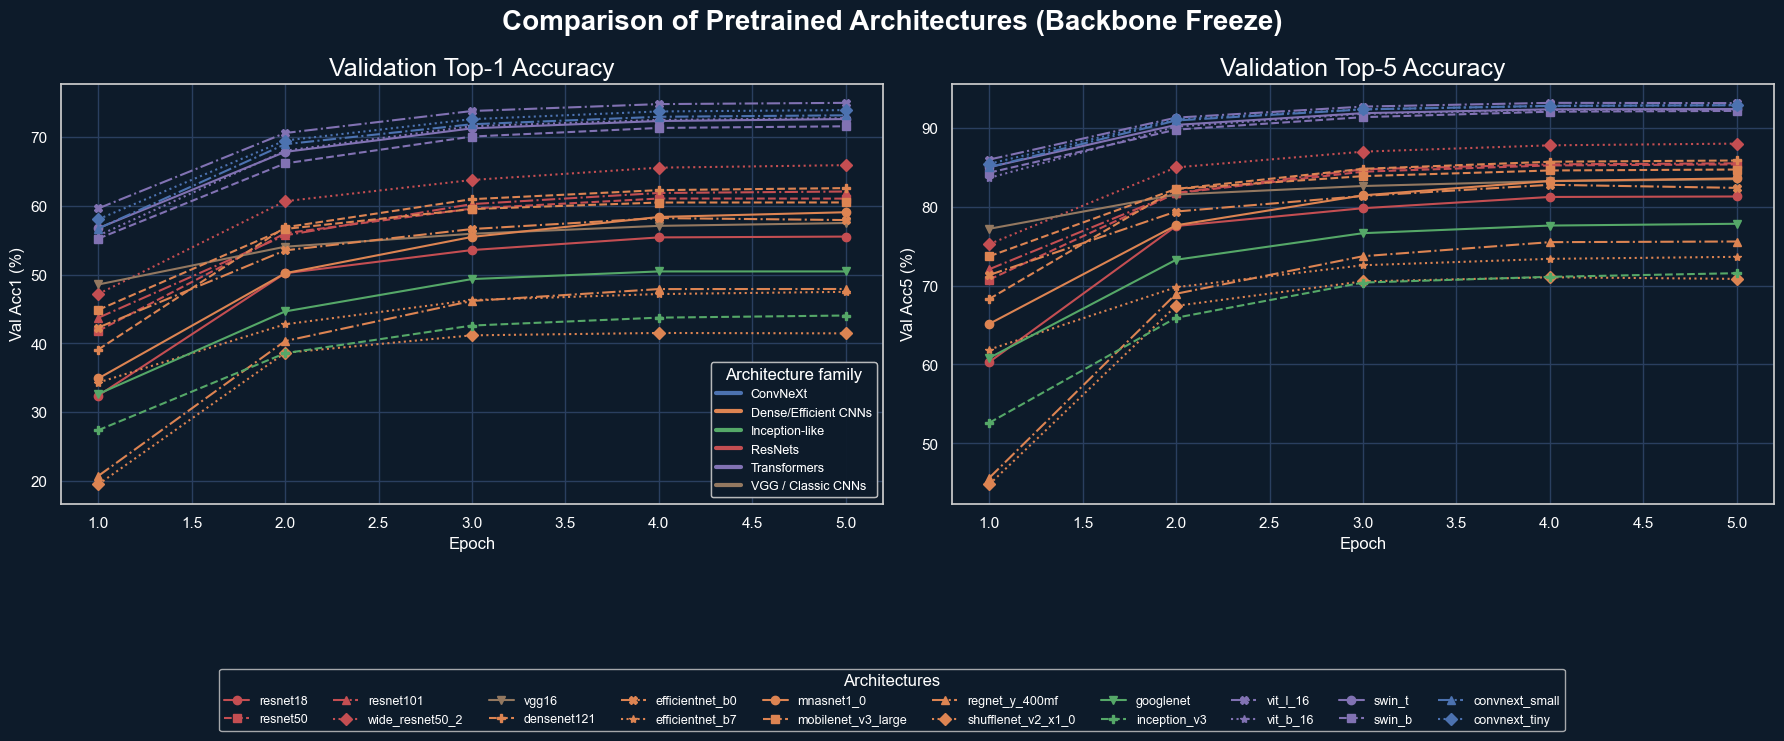

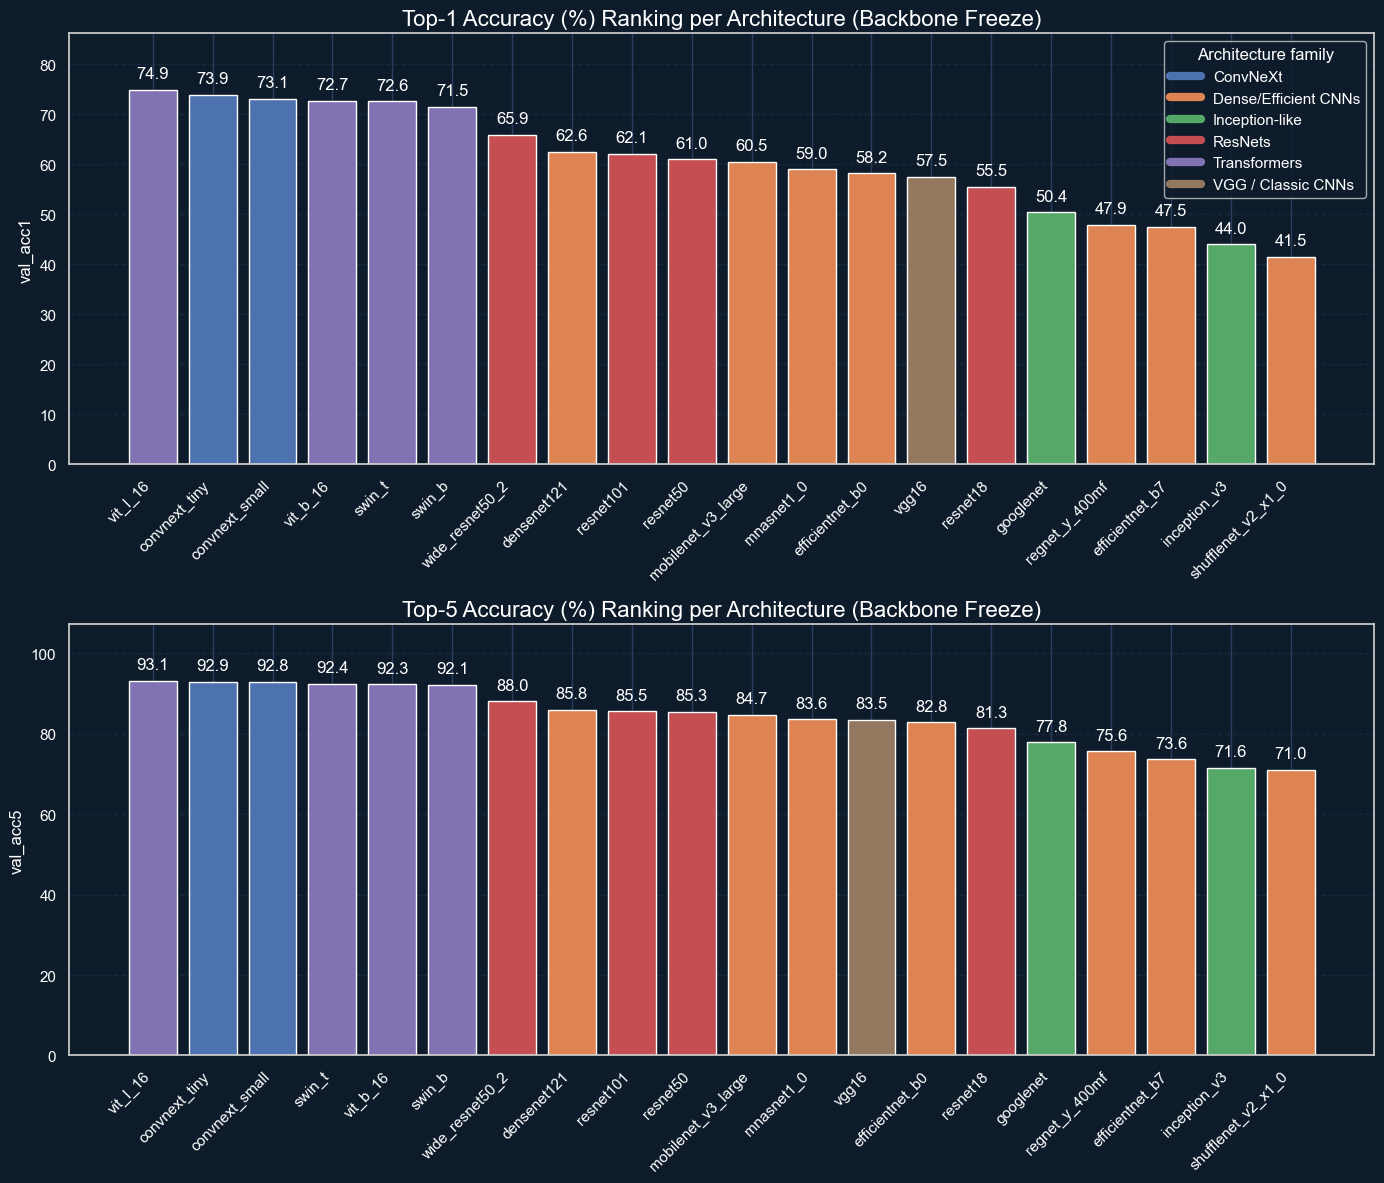

In [7]:
plot_arches(epoch_dir, arch2cat,"5", "Comparison of Pretrained Architectures (Backbone Freeze)")

fig, axes = plt.subplots(2, 1, figsize=(14, 12))
plt.rcParams["axes.titlesize"] = 16
plot_last_epoch_hist(epoch_dir, arch2cat,  "5",metric="val_acc1", 
                    title="Top-1 Accuracy (%) Ranking per Architecture (Backbone Freeze)", ax=axes[0])
plot_last_epoch_hist(epoch_dir, arch2cat,  "5",metric="val_acc5",
                     title="Top-5 Accuracy (%) Ranking per Architecture (Backbone Freeze)", 
                     loc = None, ax=axes[1])
plt.tight_layout()
plt.show()

When the backbone is frozen, the models converge rapidly: around five epochs are sufficient for the validation and test accuracies to stabilize.
The relative rankings of the architectures remain consistent across both Top-1 and Top-5 accuracy metrics, indicating stable comparative performance.

Overall, the Transformer-based models dominate this setting, achieving 71-78% Top-1 Accuracy and 92-94.5% Top-5 Accuracy. Their strong pretrained representations and global attention mechanisms allow them to transfer well even without fine-tuning the entire network.

At the opposite end, the Inception-like architectures show the weakest performance, reaching only 43.8-50.5% Top-1 and 71.4-77.8% Top-5 Accuracy, likely due to their older design and limited representational capacity compared to modern networks.

The remaining families (ResNets, Dense/Efficient CNNs, and VGG-style model) fall in between, offering a balanced compromise between performance and computational cost.

#### 2.4.4.2 Full Fine-Tuning

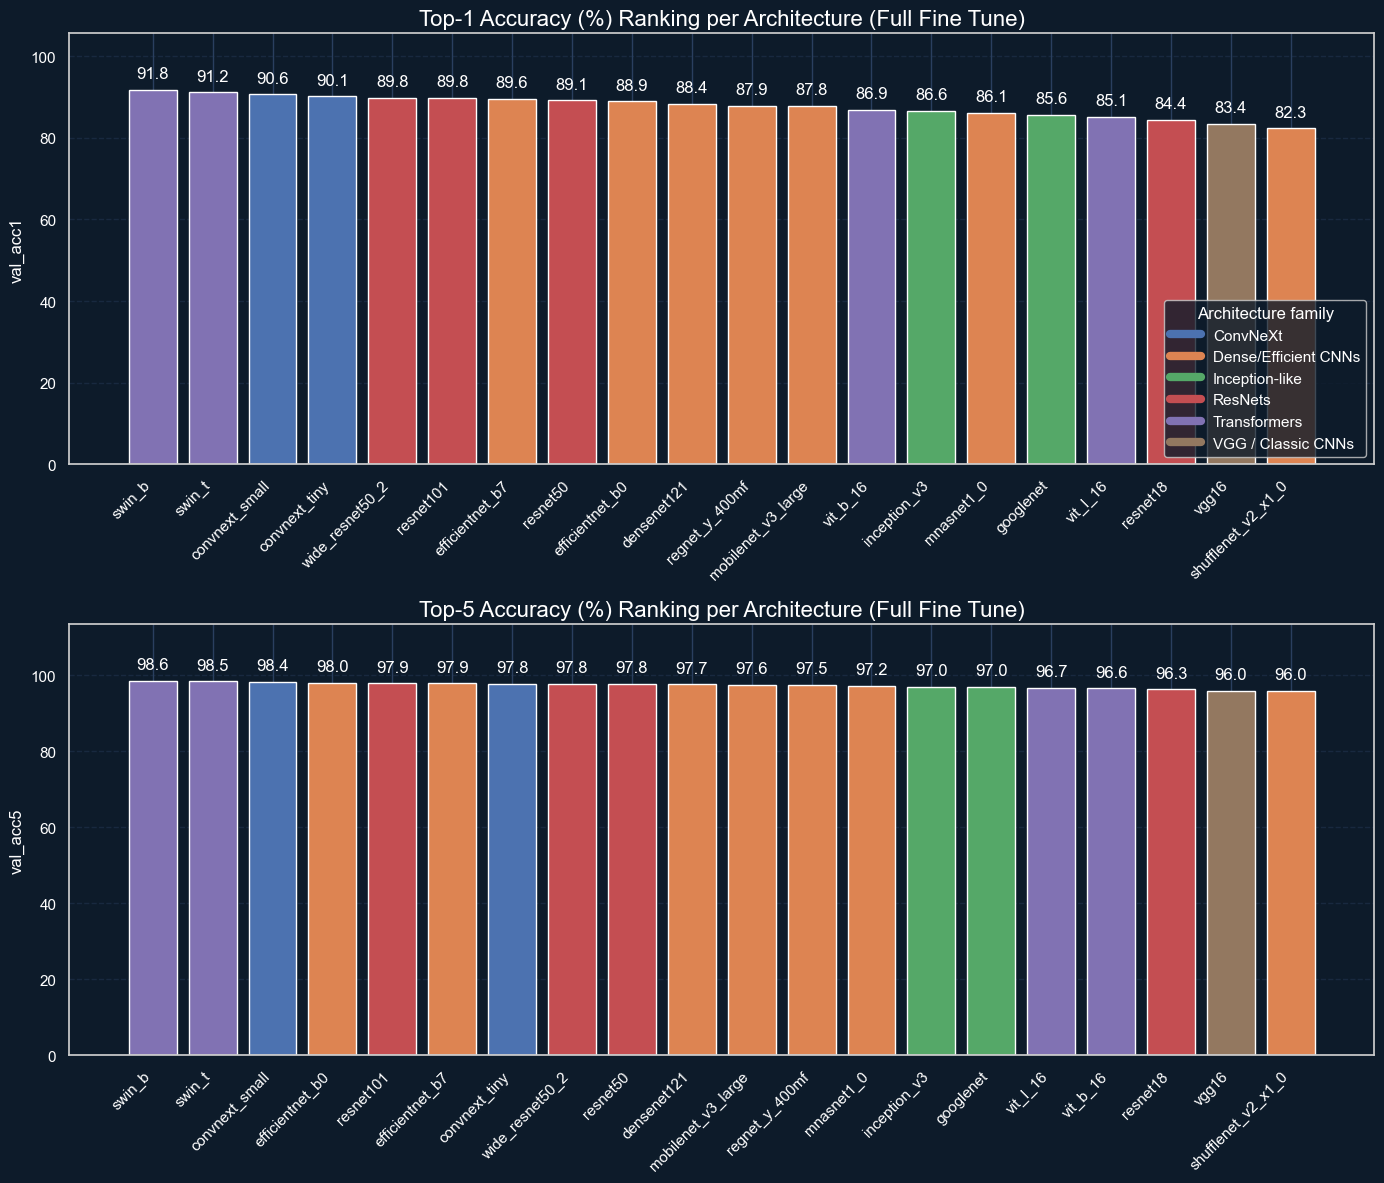

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(14, 12)) 
plt.rcParams["axes.titlesize"] = 16 
plot_last_epoch_hist(epoch_dir, arch2cat,"noFB_25",metric="val_acc1", title="Top-1 Accuracy (%) Ranking per Architecture (Full Fine Tune)", loc = "lower right", ax=axes[0]) 
plot_last_epoch_hist(epoch_dir, arch2cat,"noFB_25",metric="val_acc5", title="Top-5 Accuracy (%) Ranking per Architecture (Full Fine Tune)", loc = None, ax=axes[1]) 
plt.tight_layout() 
plt.show()

Now that we fine-tune entire networks, the relative gap between architectures largely disappears. For compute-budget reasons we limited all runs to 25 epochs; these constraints mean some models may still improve with additional training. Under this protocol, every evaluated architecture attains roughly 82-92% Top-1 Accuracy and 96-98.6% Top-5 Accuracy.

This convergence occurs because full fine-tuning lets each backbone adapt its pretrained representations to the Food-101 domain, reducing the advantage of any single inductive bias. Batch-size and optimization details (LR schedule, weight decay, mixed precision) still influence final numbers and training stability. 

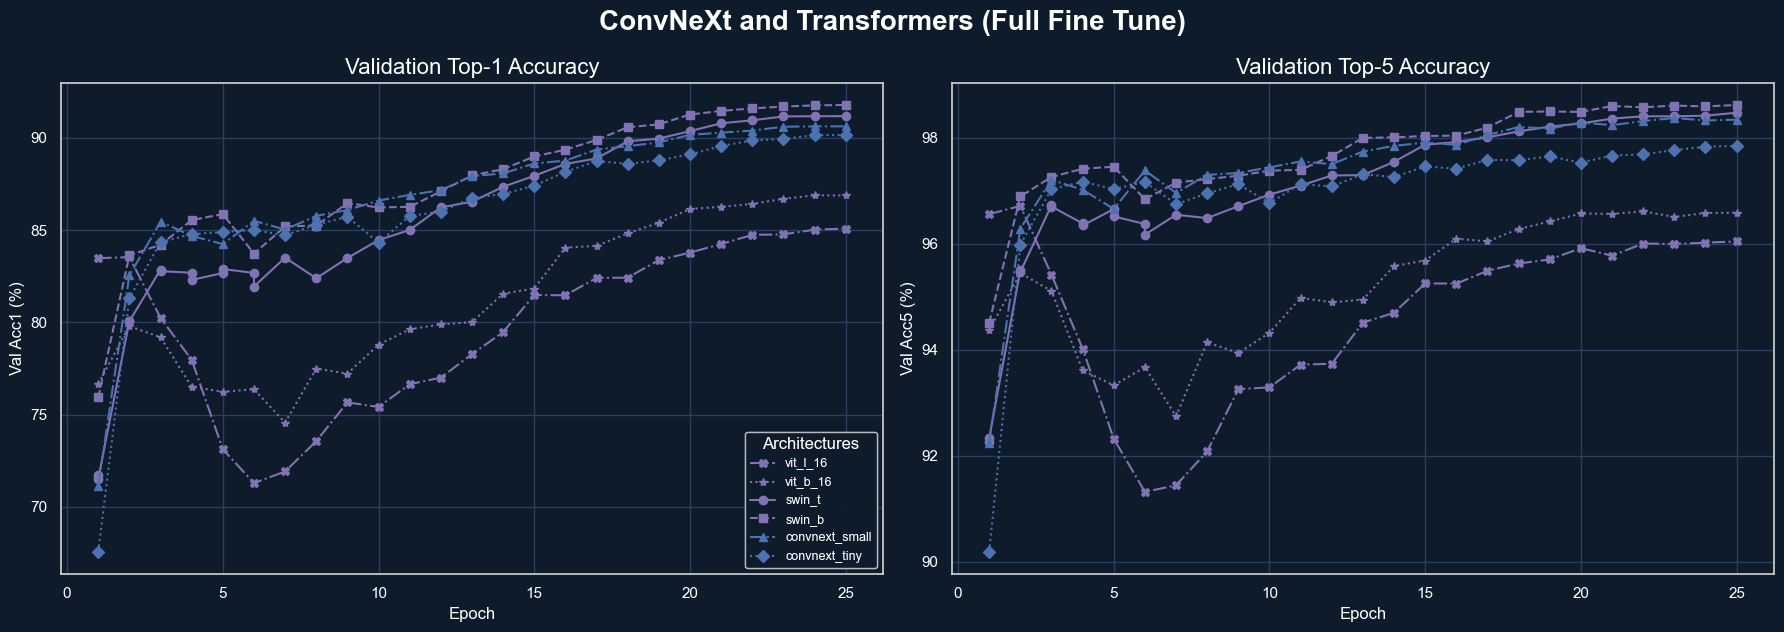

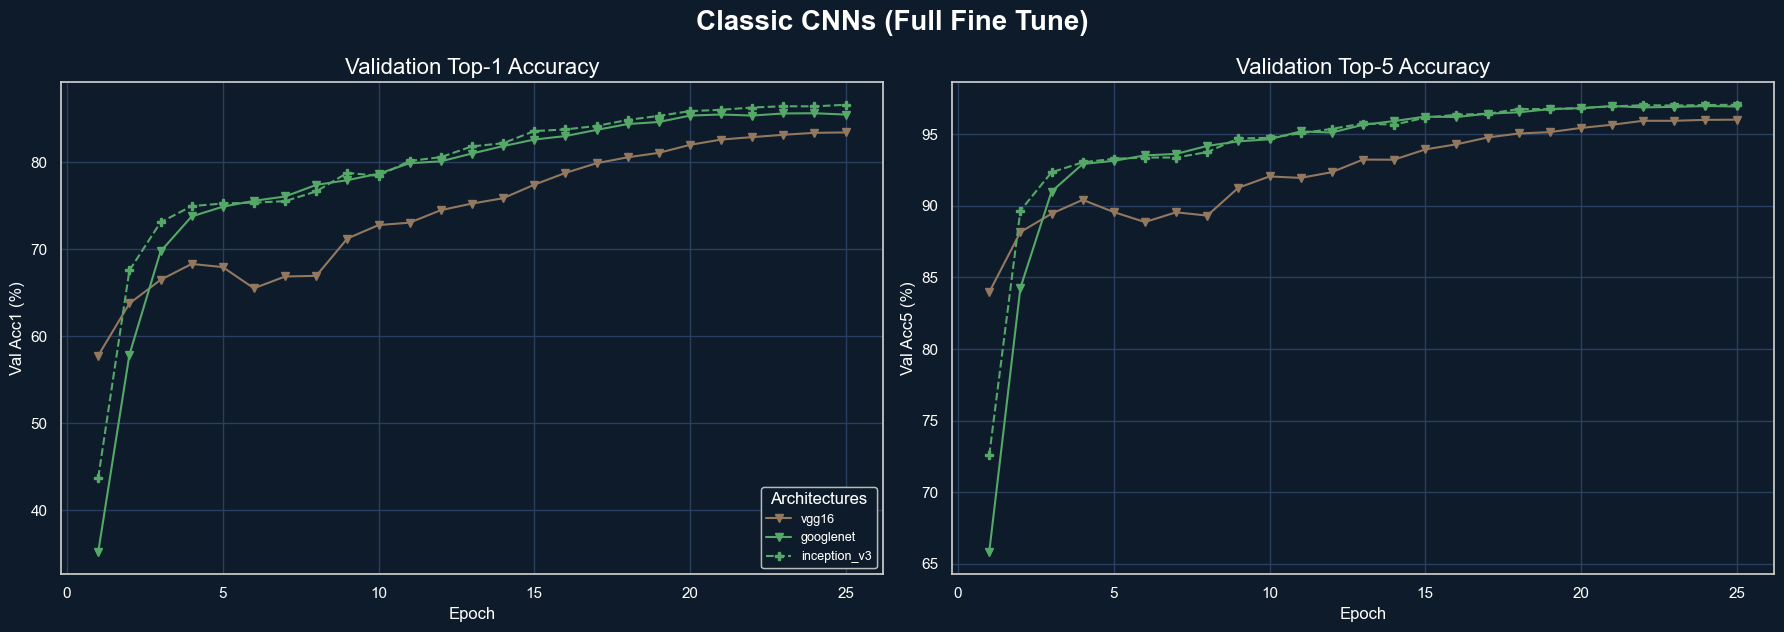

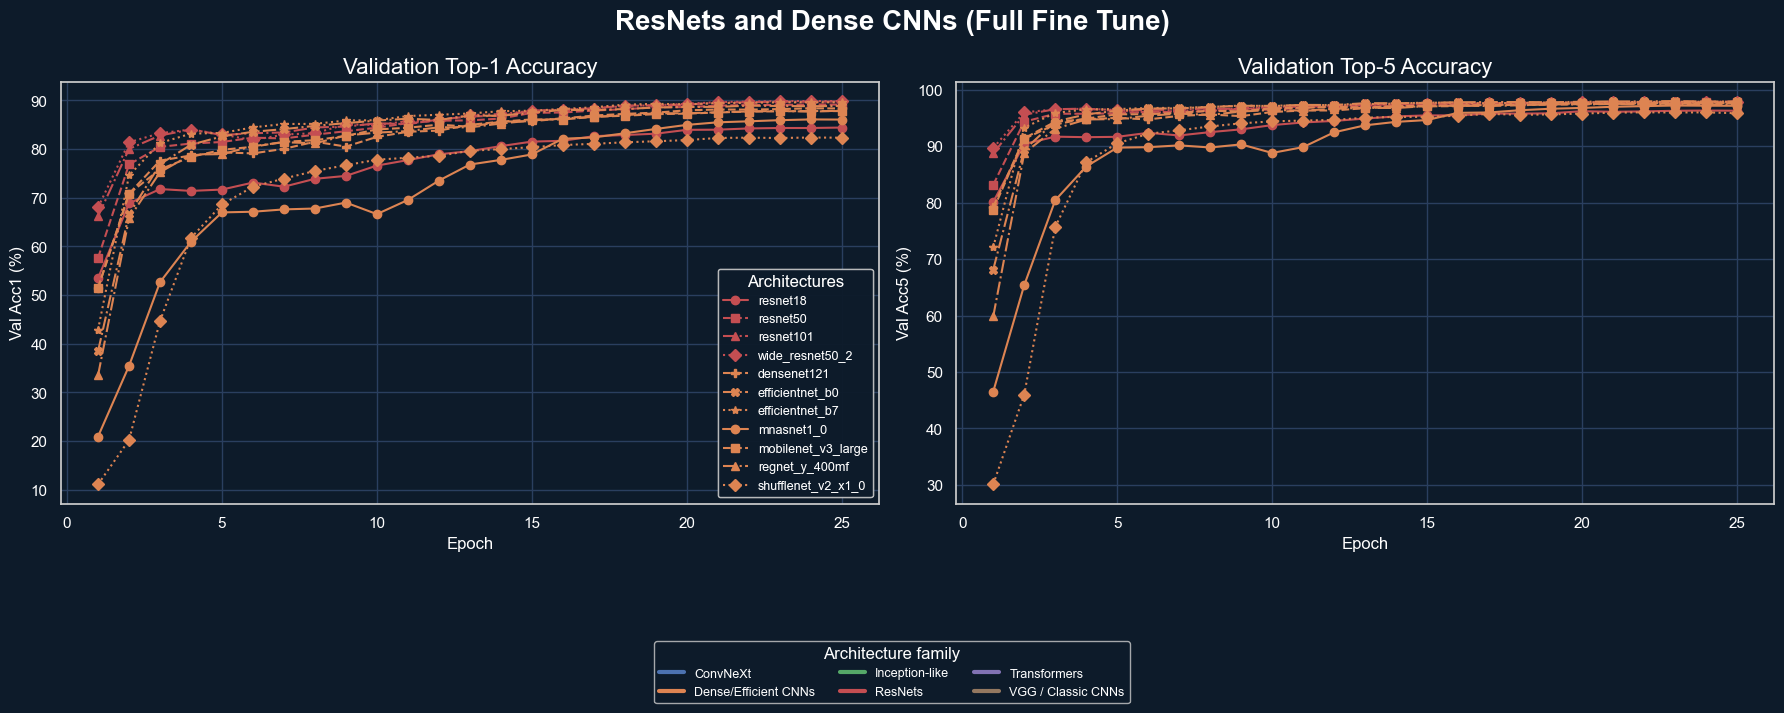

In [9]:
plot_arches(epoch_dir, arch2cat, "noFB_25", "ConvNeXt and Transformers (Full Fine Tune)", 
            families = ["Transformers","ConvNeXt"], switch_legend= True, hide_family_legend= True)
plot_arches(epoch_dir, arch2cat, "noFB_25", "Classic CNNs (Full Fine Tune)", 
            families = ["Inception-like","VGG / Classic CNNs"], switch_legend= True, hide_family_legend= True)
plot_arches(epoch_dir, arch2cat, "noFB_25", "ResNets and Dense CNNs (Full Fine Tune)", 
            families = ["Dense/Efficient CNNs","ResNets"], switch_legend= True)

Interestingly, during full fine-tuning we observe that accuracy often begins relatively high, then falls for several early epochs before recovering and rising. This behaviour can be explained by several interacting factors. Initially, the pretrained backbone and a freshly initialised head already provide a reasonable mapping from images to labels; once the entire network is unfrozen, optimization immediately modifies many parameters and temporarily perturbs those useful, preexisting representations. Large initial effective learning rates or the OneCycleLR warmup phase can amplify this effect, producing transient degradation until weights settle into a better configuration. In addition, updating batch normalization running statistics and the interplay of weight decay and optimizer dynamics can cause validation performance to oscillate early on even while training loss improves. Once the optimizer refines the weights and the internal statistics stabilise, the model typically recovers and achieves higher final accuracy.

Overall, the Swin Transformer family dominates this benchmark under our setup, with swin_b marginally outperforming swin_t (91.8% vs 91.2% Top-1 accuracy), which is strong for a 101-class task.

Their advantage stems from a combination of architectural and practical factors. Swin models use a hierarchical design that produces multi-scale feature maps similar to convolutional networks, which improves localization and object-context coupling while retaining global attention capabilities. The shifted-window attention mechanism reduces the computational cost of self-attention and enables efficient cross-window interaction, so the network can capture both local texture and longer-range structure without prohibitive compute. Compared with standard Vision Transformers, Swin preserves useful locality inductive biases that make fine-tuning more effective on image datasets with limited task-specific data. Compared with ConvNeXt and ResNet variants, Swin blends the best properties of convolutions and attention: it retains spatially coherent, multi-resolution features while providing stronger long-range reasoning through attention.

The slightly better performance of *swin_b* over *swin_t* is primarily a capacity effect: swin_b has more layers and wider channel dimensions, giving it greater representational power and a better ability to refine class separations during full fine-tuning.

For detailed analysis and diagnostics we select **swin_b**, given its superior accuracy and greater representational capacity. For the Streamlit application we use **swin_t**, because it offers comparable performance at a much lower computational cost: smaller checkpoint size, reduced memory footprint, and substantially faster inference and startup times, which improves responsiveness in a web setting. 

## 2.5 Best model analysis (Swin_B)

In this chapter, we take a closer look at **swin_b** to better understand how it learns and performs across epochs. We will examine its training dynamics, validation behaviour, and internal representations to identify what drives its strong accuracy and stability. This deeper analysis will help clarify how the model balances convergence speed, generalization, and fine-grained feature learning on the Food-101 dataset.

### 2.5.1 Accuracy and other performance metrics

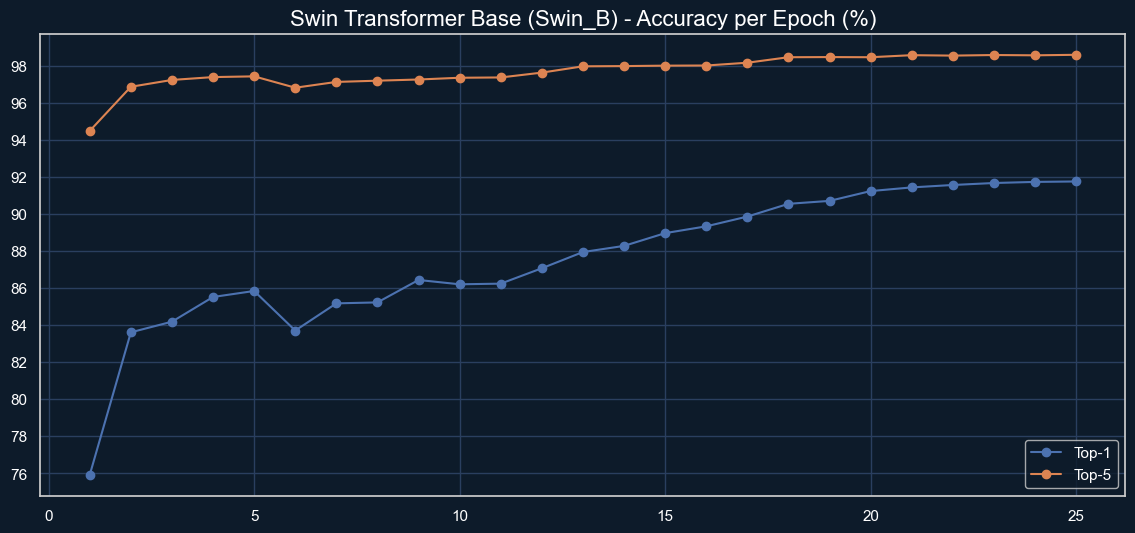

In [10]:
model_best = "swin_b_noFB_25"
model_path = os.path.join(epoch_dir,f"{model_best}.csv")
df_acc = pd.read_csv(model_path)

plt.figure(figsize=(14,6))
plt.plot(df_acc["epoch"],df_acc["val_acc1"]*100, marker='o', ms = 6, label='Top-1')
plt.plot(df_acc["epoch"],df_acc["val_acc5"]*100, marker='o', ms = 6, label='Top-5')
plt.title("Swin Transformer Base (Swin_B) - Accuracy per Epoch (%)")
plt.gca().yaxis.set_major_locator(MultipleLocator(2))
plt.legend(loc = "lower right")
plt.show()

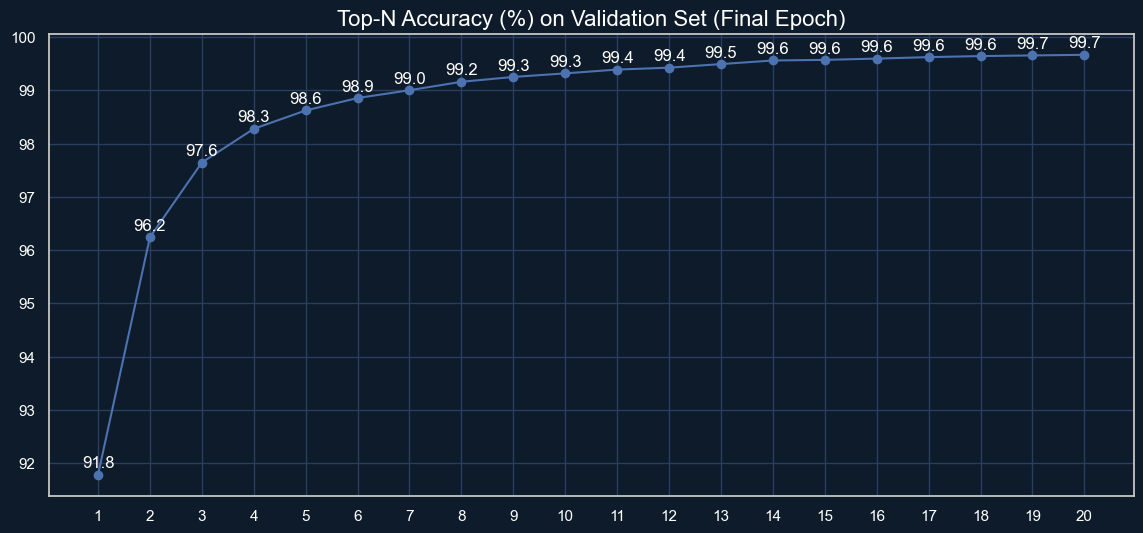

In [11]:
last_epoch = df_acc.iloc[-1]
last_epoch = last_epoch.loc[["val_acc" in ind for ind in last_epoch.index]]

plt.figure(figsize=(14,6))
plt.plot(range(1,1+len(last_epoch)),last_epoch * 100, marker='o', ms = 6)
plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.title("Top-N Accuracy (%) on Validation Set (Final Epoch)")
for i, y in enumerate(last_epoch * 100, start=1):
    plt.annotate(f"{y:.1f}", (i, y), textcoords="offset points", xytext=(0,5), ha='center')
plt.show()

The top-N accuracy further highlights the remarkable effectiveness of swin_b. With a Top-1 accuracy of 91.8% and a Top-2 accuracy of 96.2%, it becomes evident that in most misclassified cases the correct class still appears among the model’s highest confidence predictions. In practical terms, more than half of the 8.2% Top-1 errors correspond to cases where the true label ranks second, which is a strong indicator of well-calibrated confidence scores and meaningful feature discrimination in a 101-class setting. By the time we reach Top-7, the cumulative accuracy surpasses 99%, showing that the model has learned to assign substantial probability mass to only a small set of visually related categories, reflecting both robustness and fine-grained understanding of the dataset.

In [12]:
pred = np.load(os.path.join("artifacts","predictions",f"{model_best}.npz"))
y_true = pred["y_true"]
y_score = pred["y_score"]
y_pred = pred["y_pred"]

metrics = compute_metrics(y_true, y_score)
scalars_metrics, df_metrics = get_list_and_df(metrics)
df_metrics["label"] = classes
df_topk = topk_per_class_accuracies(y_true, y_score,range(1,6))
df_metrics = pd.concat([df_metrics[["label","support","precision","recall","f1","roc_auc","pr_auc"]],df_topk],axis = 1)

In [13]:
selected = {k: 100*scalars_metrics[k] for k in ['accuracy', 'precision', 'recall', 'f1','roc_auc']}
pd.Series(selected).to_frame().T.style.format("{:.2f}").hide(axis="index")

Even though the Top-1 accuracy reaches *only* 91.8%, the macro AUC stands at an exceptional 99.8%, reflecting the model’s strong discriminative ability. This means that across classes, the model consistently assigns higher scores to the correct class compared with the negatives. In other words, even when the predicted label is not the top choice, the true class still tends to receive one of the highest probabilities, showing that the network ranks classes very effectively despite occasional close confusions in final classification.

### 2.5.2 Misclassification Analysis

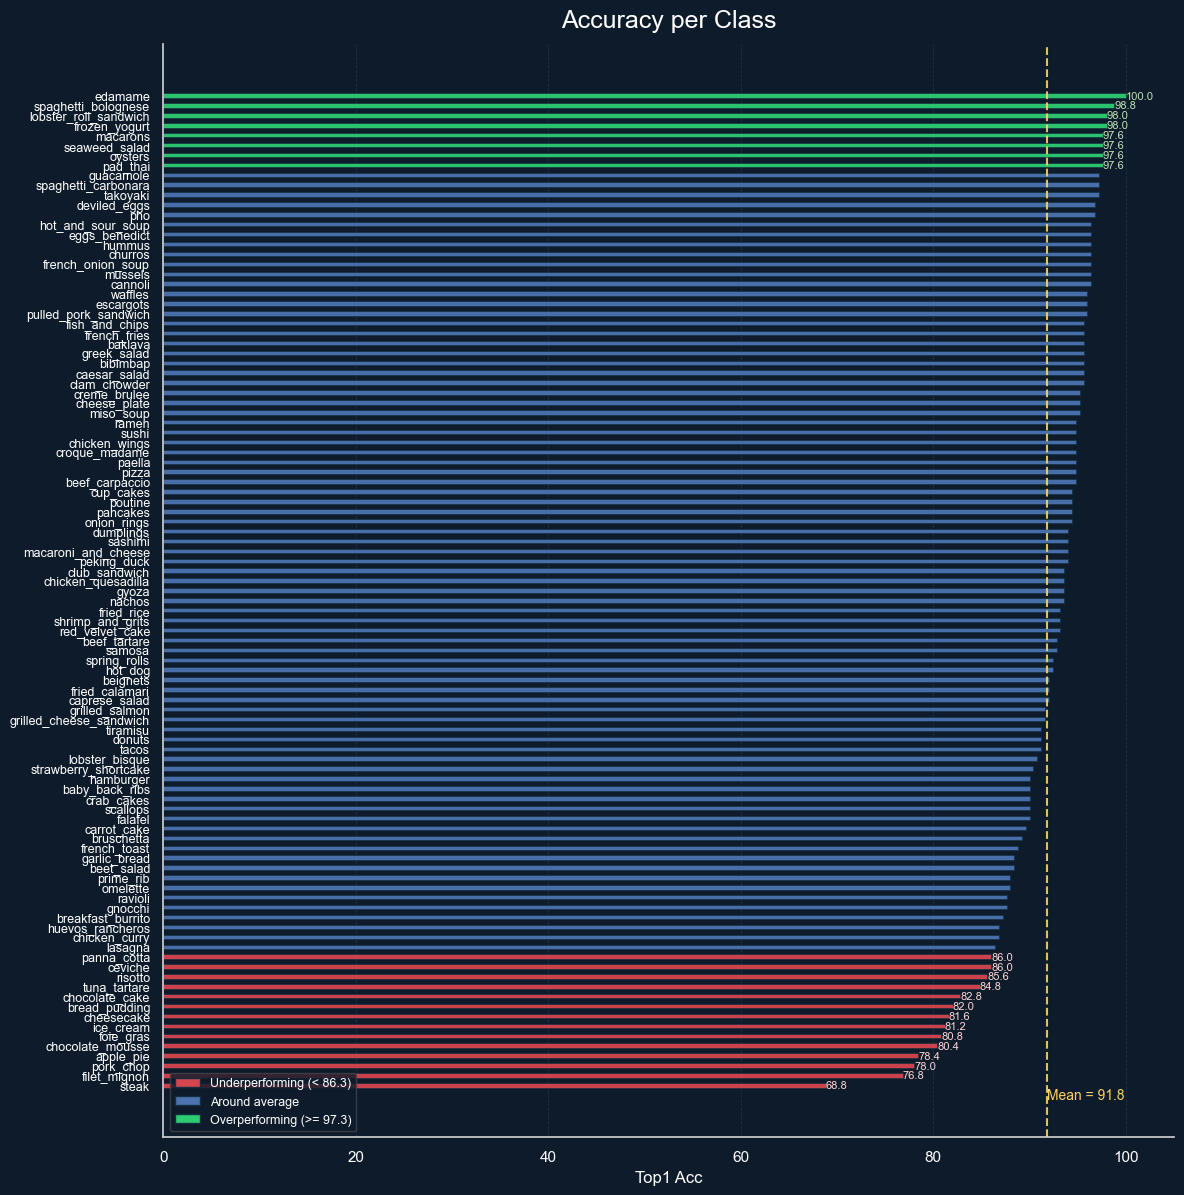

In [14]:
plot_per_class_metric(df_metrics, label_col='label', metric_col='top1_acc', title = "Accuracy per Class");
# plot_per_class_metric(df_metrics, label_col='label', metric_col='roc_auc', title = "AUC per Class");

Certain classes display exceptionally high accuracy, such as *edamame* and *spaghetti_bolognese*, with edamame even reaching perfect classification across all validation samples. These categories tend to have distinctive visual characteristics and limited overlap with others, making them easier for the model to recognize.

Conversely, some labels perform considerably worse, most notably steak, which reaches only 67.7% accuracy. This discrepancy suggests potential visual ambiguity with other meat-based dishes or variability in presentation and lighting conditions. Such results warrant a closer inspection of the underlying images and confusion patterns to determine whether the issue arises from dataset overlap, intra-class diversity, or insufficient feature differentiation by the model.

In [15]:
df_metrics.loc[df_metrics["top1_acc"]< 0.85].sort_values("top1_acc")

label  support  precision  recall        f1   roc_auc  \
93             steak      250   0.677165   0.688  0.682540  0.994708   
37      filet_mignon      250   0.761905   0.768  0.764940  0.997141   
77         pork_chop      250   0.802469   0.780  0.791075  0.996548   
0          apple_pie      250   0.852174   0.784  0.816667  0.997400   
22  chocolate_mousse      250   0.779070   0.804  0.791339  0.991830   
39         foie_gras      250   0.889868   0.808  0.846960  0.993969   
58         ice_cream      250   0.914414   0.812  0.860169  0.997329   
17        cheesecake      250   0.850000   0.816  0.832653  0.991250   
8      bread_pudding      250   0.816733   0.820  0.818363  0.990093   
21    chocolate_cake      250   0.802326   0.828  0.814961  0.996416   
99      tuna_tartare      250   0.854839   0.848  0.851406  0.998302   

      pr_auc  top1_acc  top2_acc  top3_acc  top4_acc  top5_acc  
93  0.714306     0.688     0.932     0.964     0.980     0.980  
37  0.817473     0.768     0.908     0.972     0.980     0.984  
77  0.857052     0.780     0.892     0.928     0.964     0.968  
0   0.889301     0.784     0.900     0.944     0.968     0.972  
22  0.842947     0.804     0.920     0.944     0.952     0.960  
39  0.908080     0.808     0.892     0.920     0.940     0.948  
58  0.909673     0.812     0.928     0.940     0.948     0.968  
17  0.872839     0.816     0.884     0.928     0.936     0.956  
8   0.874163     0.820     0.924     0.944     0.956     0.960  
21  0.888224     0.828     0.924     0.976     0.980     0.988  
99  0.917184     0.848     0.940     0.964     0.972     0.976

The Top-2 accuracy for steak reaches 93.2%, indicating that even when the model misclassifies an image, it frequently identifies steak as its second most probable label. This pattern suggests that the model has learned strong but not entirely decisive features for this class. In most cases, the misclassifications likely involve visually similar dishes such as *pork_chop*, *prime_rib*, or *grilled_salmon*, where texture, color, and plating resemble those of steak. The high Top-2 score therefore shows that the model’s internal representation is conceptually accurate, but the final decision boundary remains slightly blurred among closely related categories.

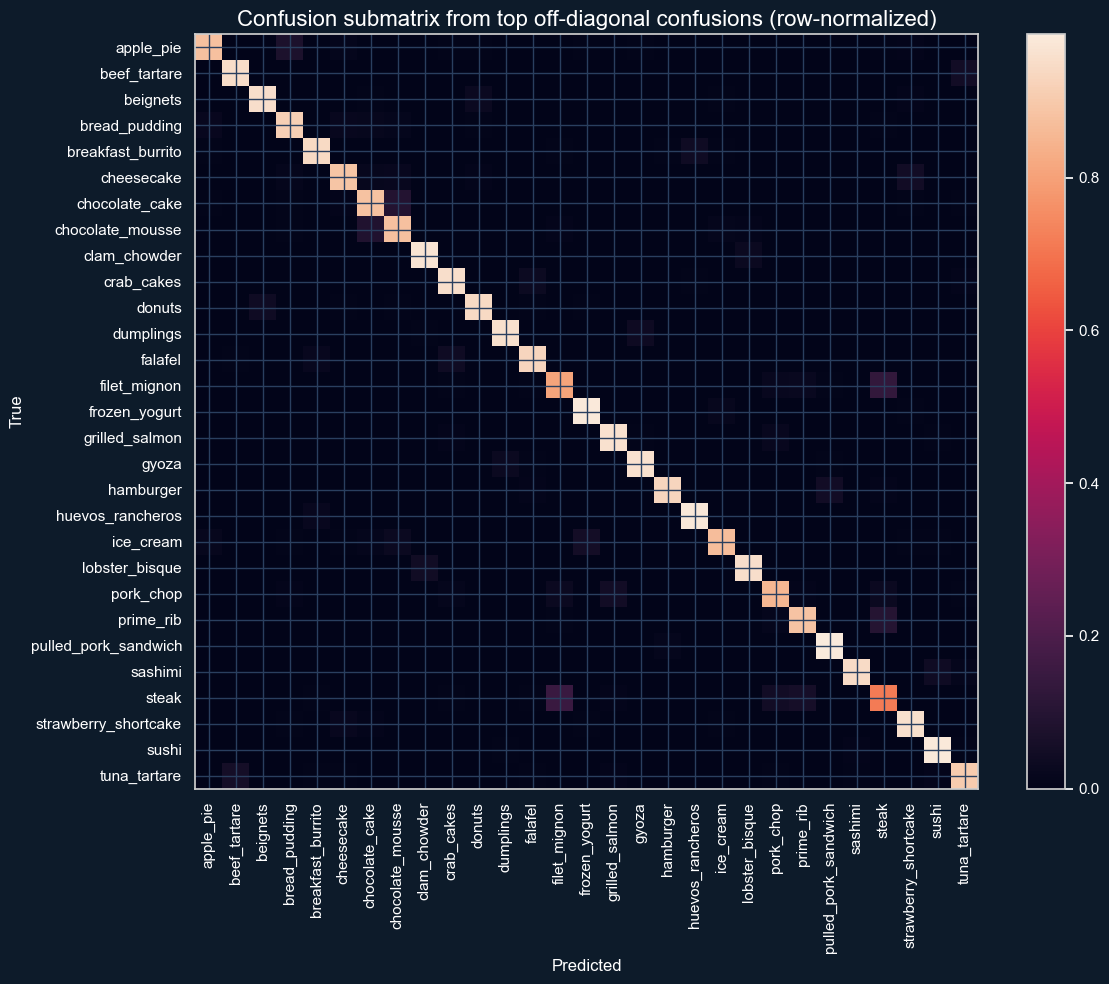

In [16]:
plot_top_confusion_submatrix(y_true, y_pred, classes, k=20, figsize=(12,10))
top_confusions_table(y_true, y_pred, classes,df_metrics)

The most frequent misclassifications occur between *steak*, *filet_mignon*, and *prime_rib*. These dishes share nearly identical color tones, textures, and presentation styles, making them visually indistinguishable even for humans in certain cases. The overlap in appearance explains the reciprocal confusion observed in the predictions. Rather than reflecting a failure of the model, this behaviour indicates that it captures the fine-grained visual similarities inherent to these categories, which differ more by culinary context than by visual cues.

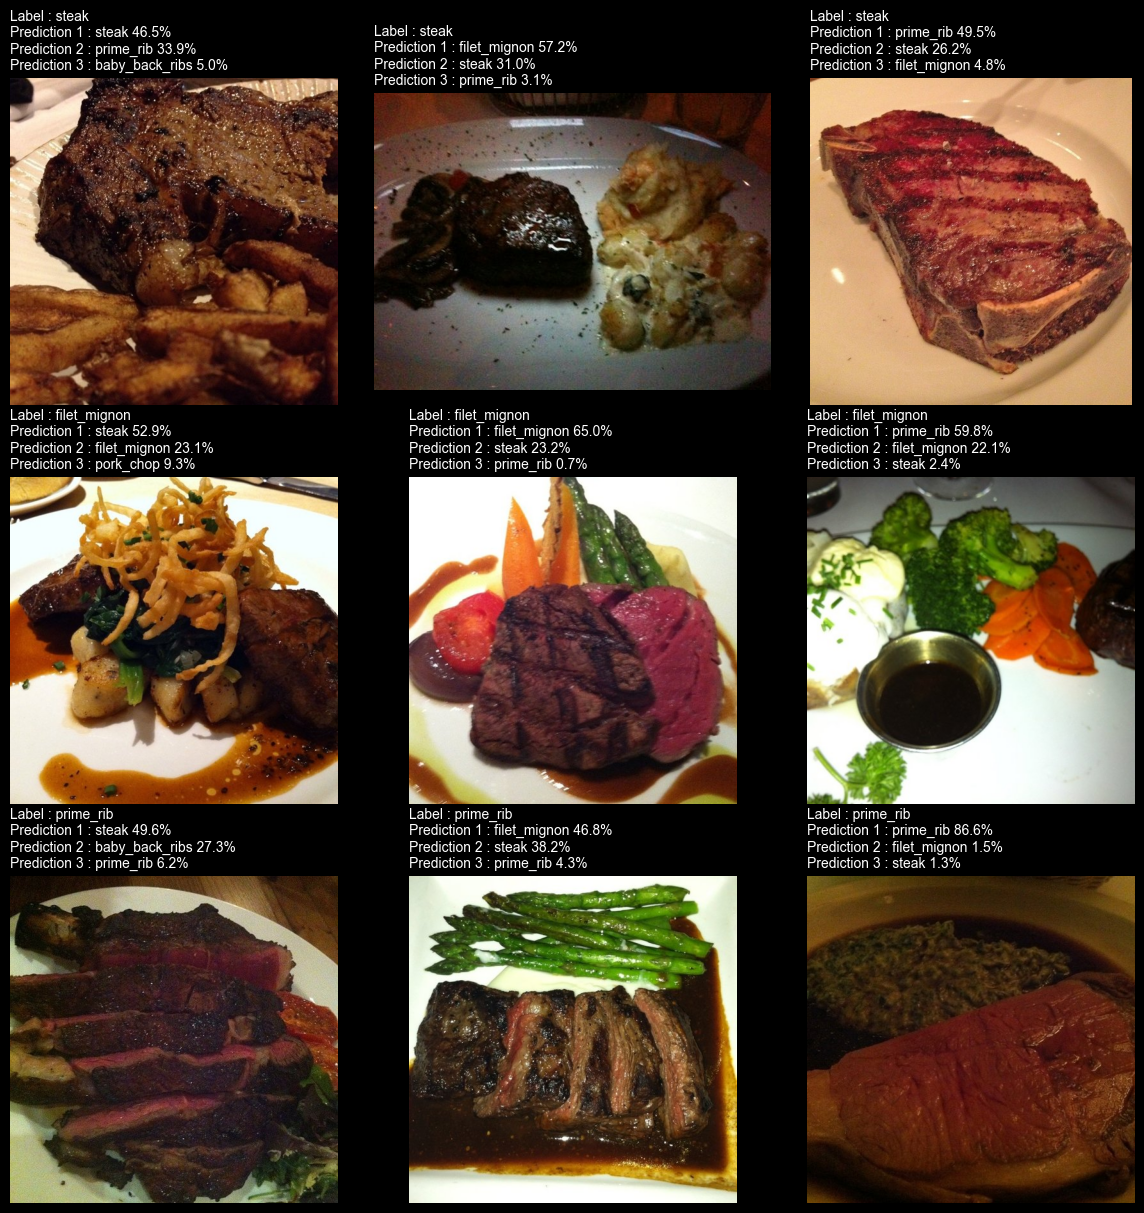

In [17]:
selected_paths, titles = build_confusion_grid(images_dir, test_txt, y_pred, y_score, 
                                              labels = ["steak", "filet_mignon", "prime_rib"], ext=".jpg")
show_grid(selected_paths, ncols=3, figsize=(12, 12), title_loc = "left", titles=titles)

We plotted the confusion matrix using images, and even for human inspection many of these cases are genuinely difficult to distinguish. The visual overlap between dishes such as steak, filet_mignon, and prime_rib is strong enough that assigning a single correct label is not always obvious. In the misclassified examples, the correct class typically appears as the second or third prediction, often with more than 20 percent confidence, which indicates that the model identifies the relevant visual cues but must choose among several nearly identical options.

### 2.5.3 Reliability and Confidence

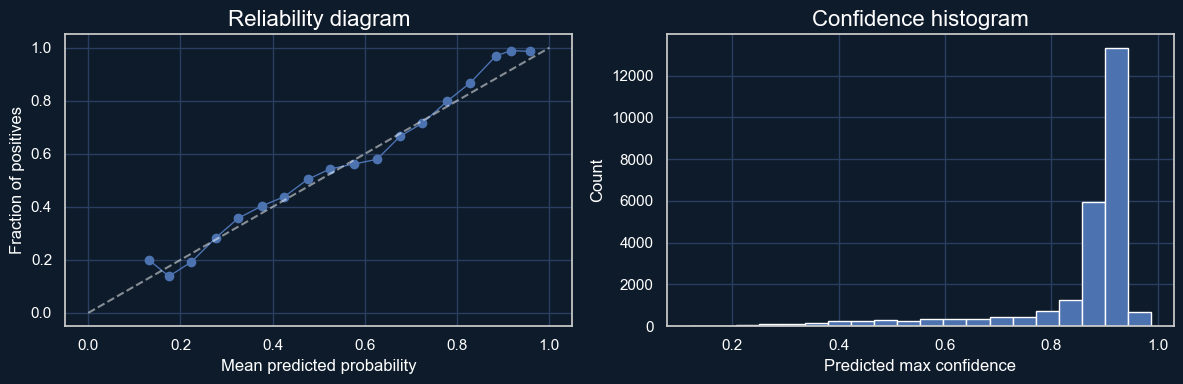

In [18]:
plot_calibration_and_histogram(y_score, y_true)

The confidence histogram shows that the model assigns high confidence to most of its predictions. A large majority of samples fall above 0.8 predicted probability, with a dense cluster between roughly 0.85 and 0.95. Very few predictions appear in the lower confidence range. This indicates that the model almost always identifies a single dominant class rather than hesitating between several options, which is consistent with its strong Top-N performance.

The reliability diagram complements this picture. The curve follows the diagonal closely across all bins, meaning that the predicted probabilities align well with the actual accuracy. When the model assigns a probability between 0.5 and 0.7, it is correct at roughly the same rate. In the highest confidence bins, the curve sits slightly above the diagonal, which indicates mild underconfidence. In other words, when the model claims around 90 percent confidence, it performs even slightly better than that.

Taken together, these plots show that swin_b is not only accurate but also well calibrated. It produces confident predictions and those confidence levels are consistent with real correctness, even in a fine-grained 101-class setting.

### 2.5.4 Embedding Space Analysis

In [19]:
mode = "sample"                
model_variant = "sequential"  

pil_t, imgfolder_t, imagenet_norm = get_transforms(img_size=img_size)
ds = make_imagefolder(images_dir, imgfolder_t)

ckpt_path = os.path.join(ckpt_dir, f"{model_best}.pth")
ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
classes = ckpt["classes"]
state_dict = ckpt["model_state_dict"]

# Rebuild the Swin-B classifier with 101 output units and load the fine-tuned weights
model = models.swin_b(weights=None)
in_features = model.head.in_features
model.head = torch.nn.Linear(in_features, len(classes))

model.load_state_dict(state_dict)
model.to(device).eval();

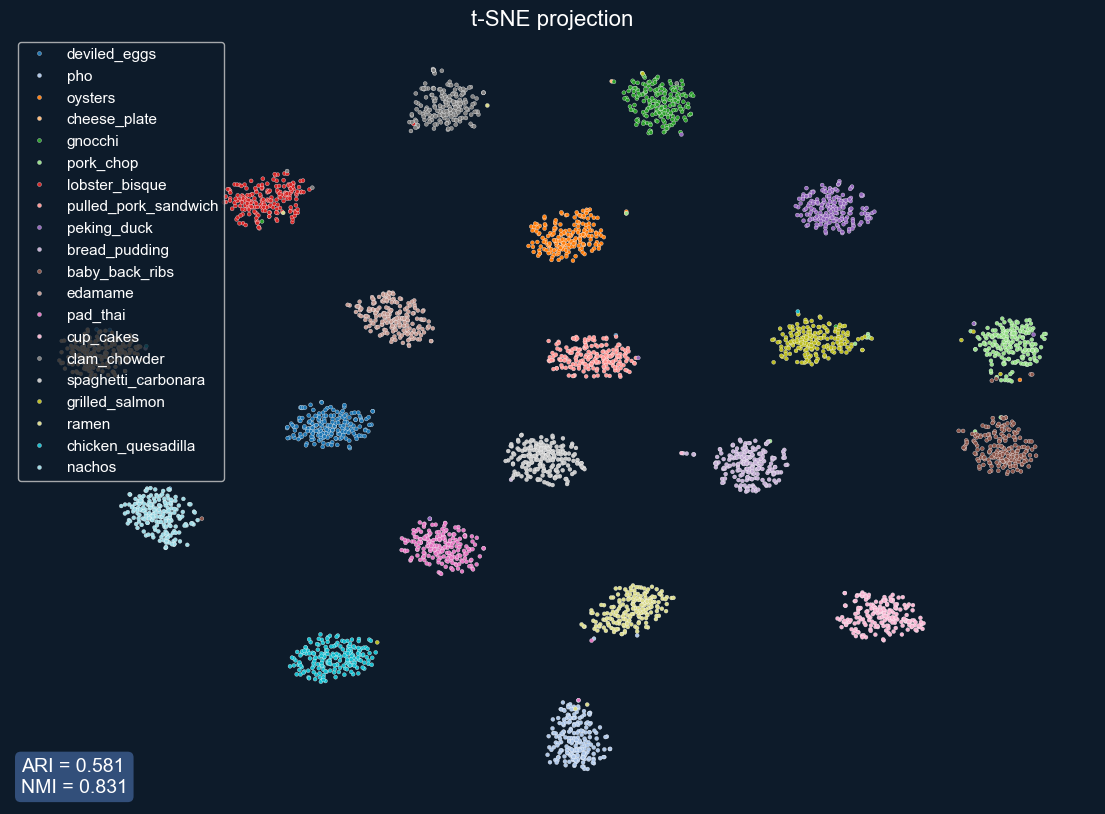

In [20]:
res = run_embedding_pipeline(
    mode="sample", ds=ds, model=model,
    pil_transform=pil_t, imagenet_norm=imagenet_norm, 
    sample_num_classes=20, sample_per_class=200, random_seed=3, pca_before_tsne=False
)
X, y, labels, Z = res["X"], res["y"], res["labels"], res["Z"]

# run k-means diagnostics only for sufficiently large X
if X.shape[0] >= 1000:
    clusters, ari, nmi = run_kmeans_metrics(X if X.shape[1] else X, y, k_clusters=101, kmeans_batch=1024, random_seed=random_seed)

plt.figure(figsize=(14,10))
ax = plt.gca()
sns.scatterplot(x=Z[:,0], y=Z[:,1], hue=labels if mode=="sample" else y, s=8, palette="tab20", legend="full")
if ari is not None and nmi is not None:
    text = f"ARI = {ari:.3f}\nNMI = {nmi:.3f}"
    ax.text(
        0.01, 0.01, text,transform=ax.transAxes,ha="left", va="bottom",fontsize=14, color="white",
        bbox=dict(boxstyle="round,pad=0.3",alpha=0.6, ec="none"),
    )
plt.title("t-SNE projection")
plt.axis("off")
plt.show()

We computed the t-SNE projection again, this time using the embeddings from the fully fine-tuned **swin_b** model. The difference compared with the projection in the [EDA notebook](1_EDA.ipynb) is immediately visible. The clusters are far more compact and the separation between classes is much clearer, which indicates that fine-tuning has reshaped the representation space to better match the structure of the Food-101 labels. While the pretrained features already captured broad visual similarities, the tuned model organizes the dataset in a way that reflects much sharper class boundaries and stronger discriminative features.

The improvement is also clear when looking at the clustering indexes. With the fine-tuned embeddings, the ARI reaches 0.581 and the NMI climbs to 0.831, compared with 0.195 and 0.514 when we used the pretrained features in the EDA notebook. These metrics quantify how well the unsupervised clusters align with the true Food-101 labels, so this jump reflects a much stronger correspondence between the learned representation space and the actual class structure. The fine-tuned model therefore produces embeddings that are not only more compact and more separated visually, but also far more aligned with the underlying ground truth.

- **Adjusted Rand Index (ARI)** measures how often pairs of images are assigned to the same or different clusters compared with the ground truth. A score of 0.581 indicates a strong level of agreement given the difficulty of the dataset, and it shows that the learned representation groups images in a way that is largely consistent with the real class structure.

- **Normalized Mutual Information (NMI)** evaluates how much information about the true classes is preserved by the clusters, independently of cluster size or label distribution. A value above 0.8 is particularly strong in a 101-class setting, showing that the fine-tuned model’s embedding space captures most of the semantic distinctions that define the dataset.

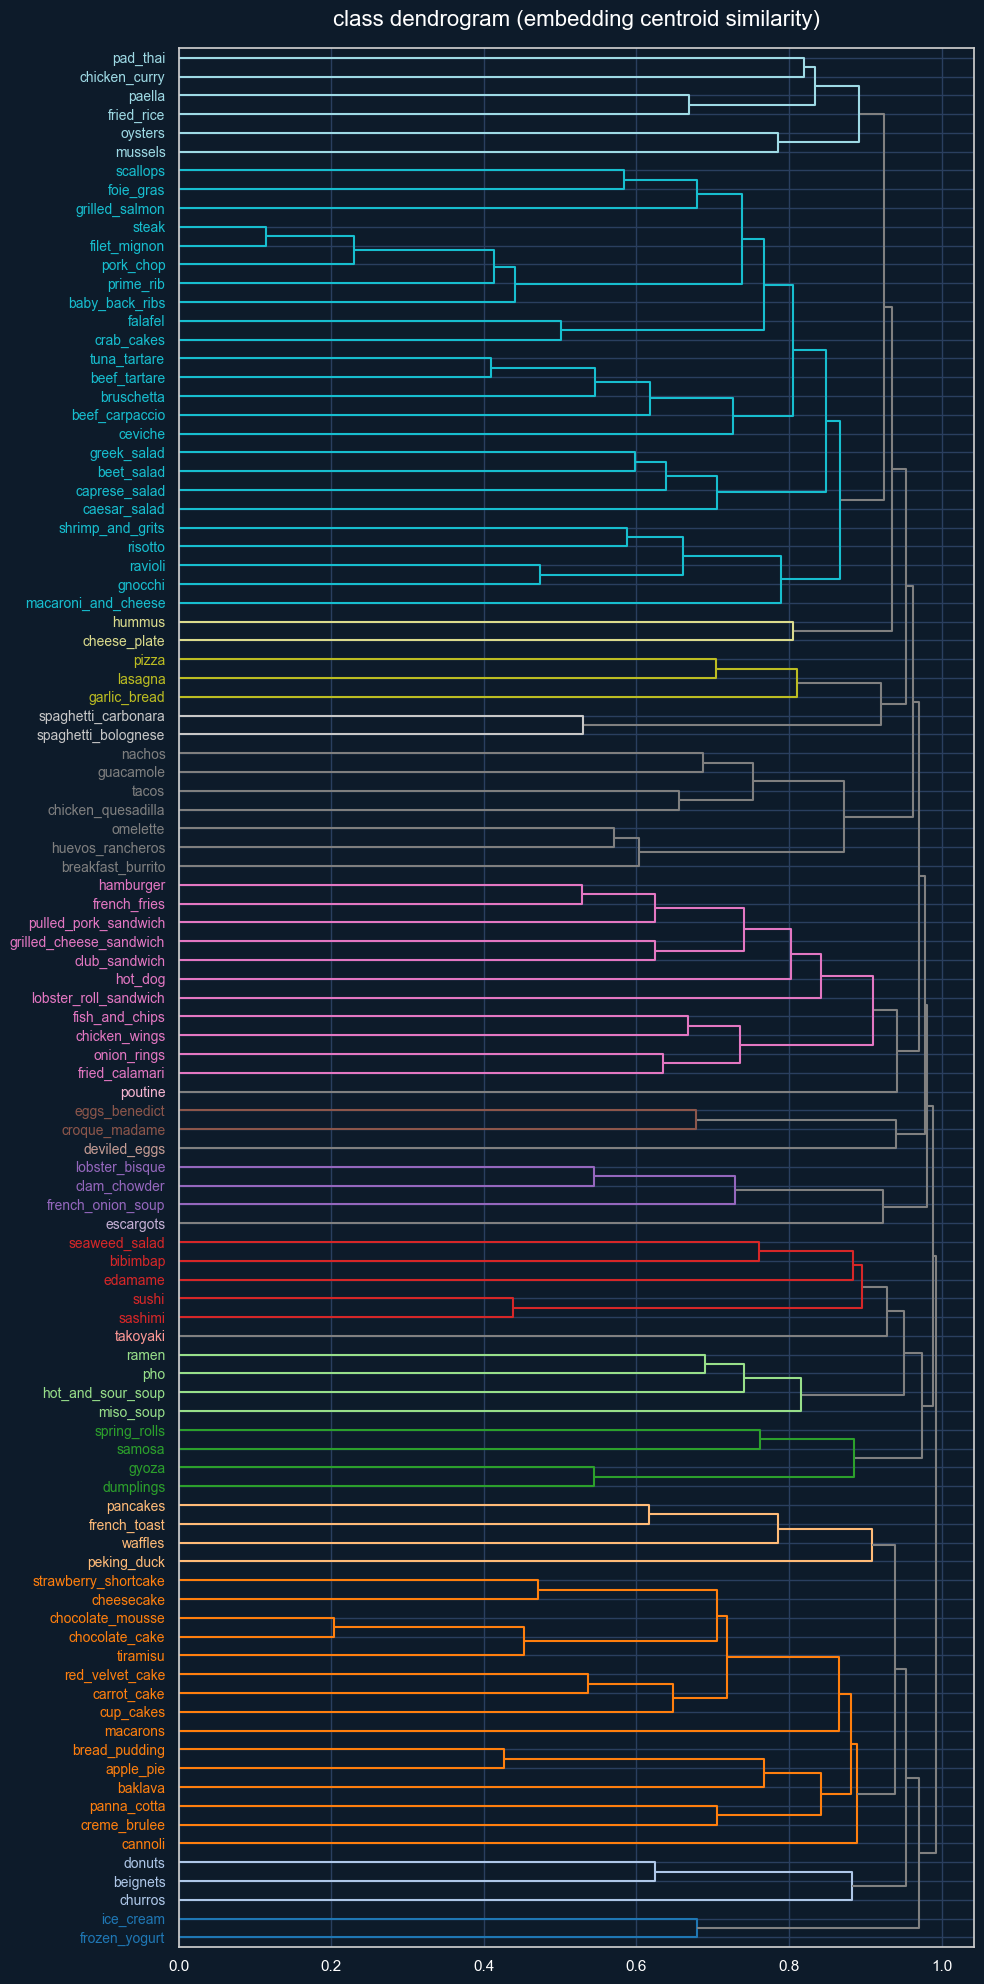

In [21]:
# centroid embedding function wrapper
embed_fn = lambda imgs: embed_batch_from_tensor(imgs, model=model, imagenet_norm=imagenet_norm,
                                                model_variant=model_variant, device=device, normalize_embeddings=False)

centroids = compute_class_centroids(source_ds=ds,
                                    classes=ds.classes,
                                    embed_batch_fn=embed_fn,
                                    imagenet_norm=imagenet_norm,
                                    centroid_samples_per_class=64,
                                    batch_size=256,
                                    model_variant=model_variant)

zlink = compute_linkage_from_centroids(centroids, method="average")
cluster_assign = assign_flat_clusters(zlink, n_dendro_clusters=20)
class_to_color, leaf_cluster, hex_palette = build_class_color_mapping(ds.classes, cluster_assign, n_dendro_clusters=20)
link_color = make_link_color_func(zlink, n=len(ds.classes), leaf_cluster=leaf_cluster, hex_palette=hex_palette)
plot_vertical_dendrogram(zlink, ds.classes, class_to_color, link_color, figsize=(10,20))

The dendrogram now shows noticeably taller branches, which indicates that the distances between class centroids are larger in the fine-tuned embedding space. In hierarchical clustering, taller branch heights correspond to greater dissimilarity between groups, so the increased vertical spread suggests that the model has pushed the classes farther apart while learning more discriminative features. In other words, the fine-tuned swin_b organizes the classes with clearer separation and stronger boundaries than what we observed with the pretrained features.

The dendrogram reveals several coherent groups that reflect strong visual and semantic similarities across the Food-101 classes.

- The first clusters gather visually simple frozen desserts (frozen_yogurt, ice_cream), followed by a trio of fried pastries (beignets, churros, donuts). A much larger dessert cluster emerges as well, containing cakes, custards, pastries, and fruit-based sweets, which naturally group together due to their shared colors, textures, and plating styles.

- Breakfast-related dishes form another group, with french_toast, pancakes, and waffles joined unexpectedly by peking_duck, likely due to overlapping color tones and presentation patterns in the embedding space. Fried starters and dumpling-like items cluster together as well (dumplings, gyoza, samosa, spring_rolls), along with a compact soup cluster (hot_and_sour_soup, miso_soup, pho, ramen).

- A distinct set of Japanese and East Asian items appears grouped together (bibimbap, edamame, sashimi, seaweed_salad, sushi), while some dishes remain isolated in their own clusters (takoyaki, escargots, deviled_eggs, poutine), reflecting strong uniqueness in their visual patterns.

- Small thematic groups also emerge around breakfast sandwiches (croque_madame, eggs_benedict) and classic pasta pairings such as spaghetti_bolognese with spaghetti_carbonara, or garlic_bread, lasagna, and pizza. Light appetizer-style foods like cheese_plate and hummus form their own compact cluster.

- The largest group consists of a broad mix of salads, meat dishes, seafood plates, and rich entrées, reflecting a wide spectrum of visually similar compositions and color palettes that still remain distinguishable from the more specialized clusters. Finally, a separate group gathers several Asian and rice-based dishes (chicken_curry, fried_rice, mussels, oysters, pad_thai, paella), which share common structural and plating characteristics.

Across all clusters, the structure reflects how the fine-tuned model organizes the dataset into visually coherent families, highlighting both clear thematic groups and a few highly distinctive classes that stand apart from the rest.

## 2.6 Conclusion

In this notebook, we evaluated a broad range of modern vision architectures and compared their behaviour under both frozen-backbone training and full fine-tuning. By running every model under the same configuration, we obtained a clear view of how capacity, computational cost, and architectural design influence performance on Food-101.

The comparison between head-only training and full fine-tuning highlighted consistent patterns. Most models benefited from updating all parameters, although the extent varied by family. Convolutional networks showed moderate gains, while transformer-based architectures experienced larger improvements but at a higher computational cost. This distinction gave us a better understanding of the trade-offs between speed, stability, and representational power.

Within this landscape, swin_b emerged as the strongest model, combining high Top-1 accuracy, excellent Top-N performance, and well-calibrated probability estimates. Its embedding space became significantly more structured after fine-tuning, as shown by the improved clustering indexes and the clearer class separation in the t-SNE projection. The misclassification analysis also revealed that most errors occurred among extremely similar classes, where even top human recognition can be uncertain.

Taken together, these results show that swin_b provides the most reliable and discriminative representation for this task, making it a solid choice for deeper analysis and interpretation in subsequent steps.

In the next notebook, we shift from model exploration to the operational side of the project, introducing the MLOps components that support training, tracking, reproducibility, and deployment, including CI/CD, Docker, and MLflow.